# To predict the next word in a sequence of words using recurrance phenomenon. Apply Recurrent neural networks to predict a single word given a input context word. Extend the concept to given a set of words in a sentence, predict the next set of words. Visulaize performance metrics and compute them to evaluate on a test sequence.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
print(f"🐍 PyTorch version: {torch.__version__}")
print("=" * 80)

🚀 Using device: cuda
🐍 PyTorch version: 2.4.0+cu118


In [2]:
# Create sample text dataset
raw_texts = [
    "the cat sat on the mat",
    "the dog ran in the park", 
    "I love to eat pizza",
    "the sun is shining bright",
    "cats and dogs are pets",
    "I love my cat very much",
    "the weather is nice today",
    "dogs love to play outside",
    "the cat loves to sleep",
    "I eat pizza every day",
    "the sun shines every morning",
    "my dog is very friendly",
    "cats like to catch mice",
    "the park is full of trees",
    "pizza is my favorite food",
    "the mat is soft and warm",
    "dogs are loyal to owners",
    "I love sunny weather today",
    "the cat sits by window",
    "eating pizza makes me happy"
]

print("📖 Raw Text Data:")
print(f"   • Total sentences: {len(raw_texts)}")
print(f"   • Sample sentences:")
for i, text in enumerate(raw_texts[:5]):
    print(f"      {i+1}. '{text}'")
print(f"   • ... and {len(raw_texts)-5} more sentences")

# Calculate basic statistics
total_words = sum(len(text.split()) for text in raw_texts)
avg_length = total_words / len(raw_texts)
print(f"\n📊 Basic Statistics:")
print(f"   • Total words across all sentences: {total_words}")
print(f"   • Average sentence length: {avg_length:.2f} words")
print(f"   • Shortest sentence: {min(len(text.split()) for text in raw_texts)} words")
print(f"   • Longest sentence: {max(len(text.split()) for text in raw_texts)} words")

📖 Raw Text Data:
   • Total sentences: 20
   • Sample sentences:
      1. 'the cat sat on the mat'
      2. 'the dog ran in the park'
      3. 'I love to eat pizza'
      4. 'the sun is shining bright'
      5. 'cats and dogs are pets'
   • ... and 15 more sentences

📊 Basic Statistics:
   • Total words across all sentences: 105
   • Average sentence length: 5.25 words
   • Shortest sentence: 5 words
   • Longest sentence: 6 words


In [3]:
print("🔧 STEP 3: TEXT PREPROCESSING")
print("=" * 50)

# Demonstrate preprocessing with one example
sample_text = "The Cat Sat On The Mat!"
print(f"📝 Preprocessing demonstration with: '{sample_text}'")
print("-" * 60)

# Step 3.1: Convert to lowercase
print("3.1 Original text:")
print(f"    Input:  '{sample_text}'")

lowercase_text = sample_text.lower()
print("3.2 Lowercase conversion:")
print(f"    Output: '{lowercase_text}'")

# Step 3.3: Remove punctuation
clean_text = re.sub(r'[^\w\s]', '', lowercase_text)
print("3.3 Punctuation removal:")
print(f"    Output: '{clean_text}'")

# Step 3.4: Handle extra spaces
final_clean = ' '.join(clean_text.split())
print("3.4 Clean extra spaces:")
print(f"    Output: '{final_clean}'")

print(f"\n🔄 Processing all {len(raw_texts)} sentences...")

# Apply preprocessing to all texts
cleaned_texts = []
for text in raw_texts:
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Clean extra spaces
    text = ' '.join(text.split())
    cleaned_texts.append(text)

print("✅ Preprocessing complete!")
print(f"\n📝 Sample preprocessed texts:")
for i in range(5):
    print(f"   Original:  '{raw_texts[i]}'")
    print(f"   Cleaned:   '{cleaned_texts[i]}'")
    print()

🔧 STEP 3: TEXT PREPROCESSING
📝 Preprocessing demonstration with: 'The Cat Sat On The Mat!'
------------------------------------------------------------
3.1 Original text:
    Input:  'The Cat Sat On The Mat!'
3.2 Lowercase conversion:
    Output: 'the cat sat on the mat!'
3.3 Punctuation removal:
    Output: 'the cat sat on the mat'
3.4 Clean extra spaces:
    Output: 'the cat sat on the mat'

🔄 Processing all 20 sentences...
✅ Preprocessing complete!

📝 Sample preprocessed texts:
   Original:  'the cat sat on the mat'
   Cleaned:   'the cat sat on the mat'

   Original:  'the dog ran in the park'
   Cleaned:   'the dog ran in the park'

   Original:  'I love to eat pizza'
   Cleaned:   'i love to eat pizza'

   Original:  'the sun is shining bright'
   Cleaned:   'the sun is shining bright'

   Original:  'cats and dogs are pets'
   Cleaned:   'cats and dogs are pets'



In [4]:
# Demonstrate tokenization with sample text
sample_cleaned = cleaned_texts[0]
print(f"📝 Tokenization demonstration with: '{sample_cleaned}'")

# Simple tokenization by splitting on spaces
tokens = sample_cleaned.split()
print(f"🔤 Tokens: {tokens}")
print(f"📊 Number of tokens: {len(tokens)}")

print(f"\n🔄 Tokenizing all texts...")

📝 Tokenization demonstration with: 'the cat sat on the mat'
🔤 Tokens: ['the', 'cat', 'sat', 'on', 'the', 'mat']
📊 Number of tokens: 6

🔄 Tokenizing all texts...


In [5]:
# Tokenize all texts
all_tokens = []
tokenized_texts = []

for text in cleaned_texts:
    tokens = text.split()
    tokenized_texts.append(tokens)
    all_tokens.extend(tokens)

print("✅ Tokenization complete!")
print(f"\n📊 Tokenization Statistics:")
print(f"   • Total tokens across all texts: {len(all_tokens)}")
print(f"   • Unique tokens: {len(set(all_tokens))}")

print(f"\n📝 Sample tokenized texts:")
for i in range(3):
    print(f"   Text {i+1}: {tokenized_texts[i]}")

✅ Tokenization complete!

📊 Tokenization Statistics:
   • Total tokens across all texts: 105
   • Unique tokens: 58

📝 Sample tokenized texts:
   Text 1: ['the', 'cat', 'sat', 'on', 'the', 'mat']
   Text 2: ['the', 'dog', 'ran', 'in', 'the', 'park']
   Text 3: ['i', 'love', 'to', 'eat', 'pizza']


In [6]:
# Show unique tokens (vocabulary)
unique_tokens = sorted(set(all_tokens))
print(f"\n🔤 Complete Vocabulary ({len(unique_tokens)} unique words):")
print(f"   {unique_tokens}")


🔤 Complete Vocabulary (58 unique words):
   ['and', 'are', 'bright', 'by', 'cat', 'catch', 'cats', 'day', 'dog', 'dogs', 'eat', 'eating', 'every', 'favorite', 'food', 'friendly', 'full', 'happy', 'i', 'in', 'is', 'like', 'love', 'loves', 'loyal', 'makes', 'mat', 'me', 'mice', 'morning', 'much', 'my', 'nice', 'of', 'on', 'outside', 'owners', 'park', 'pets', 'pizza', 'play', 'ran', 'sat', 'shines', 'shining', 'sits', 'sleep', 'soft', 'sun', 'sunny', 'the', 'to', 'today', 'trees', 'very', 'warm', 'weather', 'window']


In [7]:
#VOCABULARY BUILDING AND WORD FREQUENCY ANALYSIS
word_freq = Counter(all_tokens)
print(f"📊 Word Frequency Analysis:")
print(f"   • Total unique words: {len(word_freq)}")


📊 Word Frequency Analysis:
   • Total unique words: 58


In [8]:
print(f"\n🔝 Most frequent words:")
most_common = word_freq.most_common(10)
for i, (word, freq) in enumerate(most_common):
    print(f"   {i+1:2d}. '{word}' appears {freq} times")



🔝 Most frequent words:
    1. 'the' appears 11 times
    2. 'is' appears 6 times
    3. 'to' appears 5 times
    4. 'cat' appears 4 times
    5. 'i' appears 4 times
    6. 'love' appears 4 times
    7. 'pizza' appears 4 times
    8. 'dogs' appears 3 times
    9. 'my' appears 3 times
   10. 'mat' appears 2 times


In [9]:
print(f"\n🔻 Least frequent words:")
least_common = word_freq.most_common()[-10:]
for i, (word, freq) in enumerate(least_common):
    print(f"   {i+1:2d}. '{word}' appears {freq} time(s)")



🔻 Least frequent words:
    1. 'loyal' appears 1 time(s)
    2. 'owners' appears 1 time(s)
    3. 'sunny' appears 1 time(s)
    4. 'sits' appears 1 time(s)
    5. 'by' appears 1 time(s)
    6. 'window' appears 1 time(s)
    7. 'eating' appears 1 time(s)
    8. 'makes' appears 1 time(s)
    9. 'me' appears 1 time(s)
   10. 'happy' appears 1 time(s)


In [10]:
# Add special tokens for sequence modeling
vocab = ['<PAD>', '<UNK>', '<START>', '<END>'] + unique_tokens
vocab_size = len(vocab)

print(f"\n🎯 Final Vocabulary with Special Tokens:")
print(f"   • <PAD>: Padding token for sequences")
print(f"   • <UNK>: Unknown/out-of-vocabulary words")
print(f"   • <START>: Beginning of sequence")
print(f"   • <END>: End of sequence")
print(f"   • Total vocabulary size: {vocab_size}")

print(f"\n📝 Complete vocabulary:")
print(f"   {vocab}")


🎯 Final Vocabulary with Special Tokens:
   • <PAD>: Padding token for sequences
   • <UNK>: Unknown/out-of-vocabulary words
   • <START>: Beginning of sequence
   • <END>: End of sequence
   • Total vocabulary size: 62

📝 Complete vocabulary:
   ['<PAD>', '<UNK>', '<START>', '<END>', 'and', 'are', 'bright', 'by', 'cat', 'catch', 'cats', 'day', 'dog', 'dogs', 'eat', 'eating', 'every', 'favorite', 'food', 'friendly', 'full', 'happy', 'i', 'in', 'is', 'like', 'love', 'loves', 'loyal', 'makes', 'mat', 'me', 'mice', 'morning', 'much', 'my', 'nice', 'of', 'on', 'outside', 'owners', 'park', 'pets', 'pizza', 'play', 'ran', 'sat', 'shines', 'shining', 'sits', 'sleep', 'soft', 'sun', 'sunny', 'the', 'to', 'today', 'trees', 'very', 'warm', 'weather', 'window']


In [11]:
# WORD-TO-INDEX AND INDEX-TO-WORD MAPPING
# Create word-to-index mapping
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

print(f"📊 Mapping Statistics:")
print(f"   • Vocabulary size: {len(word_to_idx)}")
print(f"   • Index range: 0 to {len(word_to_idx)-1}")

print(f"\n🔤 Word to Index Mapping (first 15 entries):")
for i, (word, idx) in enumerate(list(word_to_idx.items())[:15]):
    print(f"   '{word}' → {idx}")

print(f"\n🔢 Index to Word Mapping (first 15 entries):")
for i in range(15):
    print(f"   {i} → '{idx_to_word[i]}'")

📊 Mapping Statistics:
   • Vocabulary size: 62
   • Index range: 0 to 61

🔤 Word to Index Mapping (first 15 entries):
   '<PAD>' → 0
   '<UNK>' → 1
   '<START>' → 2
   '<END>' → 3
   'and' → 4
   'are' → 5
   'bright' → 6
   'by' → 7
   'cat' → 8
   'catch' → 9
   'cats' → 10
   'day' → 11
   'dog' → 12
   'dogs' → 13
   'eat' → 14

🔢 Index to Word Mapping (first 15 entries):
   0 → '<PAD>'
   1 → '<UNK>'
   2 → '<START>'
   3 → '<END>'
   4 → 'and'
   5 → 'are'
   6 → 'bright'
   7 → 'by'
   8 → 'cat'
   9 → 'catch'
   10 → 'cats'
   11 → 'day'
   12 → 'dog'
   13 → 'dogs'
   14 → 'eat'


In [12]:
# Demonstrate conversion with sample text
sample_tokens = tokenized_texts[0]
print(f"\n📝 Conversion demonstration:")
print(f"   Original tokens: {sample_tokens}")

# Convert to indices
sample_indices = [word_to_idx[word] for word in sample_tokens]
print(f"   Token indices:   {sample_indices}")

# Convert back to words
recovered_tokens = [idx_to_word[idx] for idx in sample_indices]
print(f"   Recovered tokens: {recovered_tokens}")
print(f"   ✅ Conversion successful: {sample_tokens == recovered_tokens}")


📝 Conversion demonstration:
   Original tokens: ['the', 'cat', 'sat', 'on', 'the', 'mat']
   Token indices:   [54, 8, 46, 38, 54, 30]
   Recovered tokens: ['the', 'cat', 'sat', 'on', 'the', 'mat']
   ✅ Conversion successful: True


In [13]:
# CREATING WORD-TO-WORD TRAINING PAIRS
training_pairs = []
input_words = []
target_words = []

# Process each sentence
for sentence_idx, tokens in enumerate(tokenized_texts):
    # Add START token at beginning
    extended_tokens = ['<START>'] + tokens + ['<END>']
    
    # Create pairs: each word predicts the next word
    for i in range(len(extended_tokens) - 1):
        current_word = extended_tokens[i]
        next_word = extended_tokens[i + 1]
        
        training_pairs.append((current_word, next_word))
        input_words.append(current_word)
        target_words.append(next_word)

print(f"📊 Training Data Statistics:")
print(f"   • Total training pairs: {len(training_pairs)}")
print(f"   • Unique input words: {len(set(input_words))}")
print(f"   • Unique target words: {len(set(target_words))}")

print(f"\n📝 Sample training pairs (first 15):")
for i in range(15):
    current, next_word = training_pairs[i]
    print(f"   {i+1:2d}. '{current}' → '{next_word}'")

📊 Training Data Statistics:
   • Total training pairs: 125
   • Unique input words: 59
   • Unique target words: 59

📝 Sample training pairs (first 15):
    1. '<START>' → 'the'
    2. 'the' → 'cat'
    3. 'cat' → 'sat'
    4. 'sat' → 'on'
    5. 'on' → 'the'
    6. 'the' → 'mat'
    7. 'mat' → '<END>'
    8. '<START>' → 'the'
    9. 'the' → 'dog'
   10. 'dog' → 'ran'
   11. 'ran' → 'in'
   12. 'in' → 'the'
   13. 'the' → 'park'
   14. 'park' → '<END>'
   15. '<START>' → 'i'


In [14]:
# Show pairs from different sentences
print(f"\n📖 Training pairs by sentence:")
pair_idx = 0
for sentence_idx, tokens in enumerate(tokenized_texts[:3]):
    extended_tokens = ['<START>'] + tokens + ['<END>']
    print(f"   Sentence {sentence_idx+1}: {' '.join(tokens)}")
    sentence_pairs = []
    for i in range(len(extended_tokens) - 1):
        sentence_pairs.append(f"'{extended_tokens[i]}' → '{extended_tokens[i+1]}'")
    print(f"   Pairs: {', '.join(sentence_pairs)}")
    print()


📖 Training pairs by sentence:
   Sentence 1: the cat sat on the mat
   Pairs: '<START>' → 'the', 'the' → 'cat', 'cat' → 'sat', 'sat' → 'on', 'on' → 'the', 'the' → 'mat', 'mat' → '<END>'

   Sentence 2: the dog ran in the park
   Pairs: '<START>' → 'the', 'the' → 'dog', 'dog' → 'ran', 'ran' → 'in', 'in' → 'the', 'the' → 'park', 'park' → '<END>'

   Sentence 3: i love to eat pizza
   Pairs: '<START>' → 'i', 'i' → 'love', 'love' → 'to', 'to' → 'eat', 'eat' → 'pizza', 'pizza' → '<END>'



In [15]:
# CONVERT TRAINING PAIRS TO NUMERICAL FORMAT
# Convert word pairs to index pairs
input_indices = []
target_indices = []

for current_word, next_word in training_pairs:
    # Convert words to indices
    input_idx = word_to_idx[current_word]
    target_idx = word_to_idx[next_word]
    
    input_indices.append(input_idx)
    target_indices.append(target_idx)

print(f"📊 Numerical Data Statistics:")
print(f"   • Input indices range: {min(input_indices)} to {max(input_indices)}")
print(f"   • Target indices range: {min(target_indices)} to {max(target_indices)}")
print(f"   • Total training samples: {len(input_indices)}")

📊 Numerical Data Statistics:
   • Input indices range: 2 to 61
   • Target indices range: 3 to 61
   • Total training samples: 125


In [16]:
print(f"\n🔤 Word to Index Conversion Examples:")
for i in range(10):
    current_word, next_word = training_pairs[i]
    input_idx, target_idx = input_indices[i], target_indices[i]
    print(f"   {i+1:2d}. '{current_word}' ({input_idx}) → '{next_word}' ({target_idx})")



🔤 Word to Index Conversion Examples:
    1. '<START>' (2) → 'the' (54)
    2. 'the' (54) → 'cat' (8)
    3. 'cat' (8) → 'sat' (46)
    4. 'sat' (46) → 'on' (38)
    5. 'on' (38) → 'the' (54)
    6. 'the' (54) → 'mat' (30)
    7. 'mat' (30) → '<END>' (3)
    8. '<START>' (2) → 'the' (54)
    9. 'the' (54) → 'dog' (12)
   10. 'dog' (12) → 'ran' (45)


In [17]:
# Convert to PyTorch tensors
X_train = torch.tensor(input_indices, dtype=torch.long)
y_train = torch.tensor(target_indices, dtype=torch.long)

In [18]:
print(f"\n🔥 PyTorch Tensors Created:")
print(f"   • Input tensor shape: {X_train.shape}")
print(f"   • Target tensor shape: {y_train.shape}")
print(f"   • Input tensor dtype: {X_train.dtype}")
print(f"   • Target tensor dtype: {y_train.dtype}")

print(f"\n📊 Sample tensor data:")
print(f"   • First 10 input indices:  {X_train[:10].tolist()}")
print(f"   • First 10 target indices: {y_train[:10].tolist()}")


🔥 PyTorch Tensors Created:
   • Input tensor shape: torch.Size([125])
   • Target tensor shape: torch.Size([125])
   • Input tensor dtype: torch.int64
   • Target tensor dtype: torch.int64

📊 Sample tensor data:
   • First 10 input indices:  [2, 54, 8, 46, 38, 54, 30, 2, 54, 12]
   • First 10 target indices: [54, 8, 46, 38, 54, 30, 3, 54, 12, 45]


In [19]:
# Model hyperparameters
embedding_dim = 32      # Dimension of word embeddings
hidden_dim = 64         # Hidden dimension of RNN
num_layers = 1          # Number of RNN layers
dropout_rate = 0.2      # Dropout rate for regularization

# Training hyperparameters
learning_rate = 0.01    # Learning rate for optimizer
num_epochs = 50         # Number of training epochs
batch_size = 16         # Batch size for training

# Data split
train_size = int(0.8 * len(X_train))  # 80% for training
test_size = len(X_train) - train_size  # 20% for testing

print(f"🏗️ Model Hyperparameters:")
print(f"   • Vocabulary size: {vocab_size}")
print(f"   • Embedding dimension: {embedding_dim}")
print(f"   • Hidden dimension: {hidden_dim}")
print(f"   • Number of RNN layers: {num_layers}")
print(f"   • Dropout rate: {dropout_rate}")

print(f"\n🎯 Training Hyperparameters:")
print(f"   • Learning rate: {learning_rate}")
print(f"   • Number of epochs: {num_epochs}")
print(f"   • Batch size: {batch_size}")

print(f"\n📊 Data Split:")
print(f"   • Total samples: {len(X_train)}")
print(f"   • Training samples: {train_size} ({train_size/len(X_train)*100:.1f}%)")
print(f"   • Testing samples: {test_size} ({test_size/len(X_train)*100:.1f}%)")

🏗️ Model Hyperparameters:
   • Vocabulary size: 62
   • Embedding dimension: 32
   • Hidden dimension: 64
   • Number of RNN layers: 1
   • Dropout rate: 0.2

🎯 Training Hyperparameters:
   • Learning rate: 0.01
   • Number of epochs: 50
   • Batch size: 16

📊 Data Split:
   • Total samples: 125
   • Training samples: 100 (80.0%)
   • Testing samples: 25 (20.0%)


In [20]:
# Calculate derived parameters
total_parameters = (vocab_size * embedding_dim +  # Embedding layer
                   (embedding_dim + hidden_dim + 1) * hidden_dim +  # RNN input
                   hidden_dim * hidden_dim +  # RNN hidden
                   (hidden_dim + 1) * vocab_size)  # Output layer

print(f"\n🧮 Estimated Model Parameters:")
print(f"   • Embedding parameters: {vocab_size * embedding_dim:,}")
print(f"   • RNN parameters: ~{(embedding_dim + hidden_dim + 1) * hidden_dim + hidden_dim * hidden_dim:,}")
print(f"   • Output parameters: {(hidden_dim + 1) * vocab_size:,}")
print(f"   • Total estimated: ~{total_parameters:,}")


🧮 Estimated Model Parameters:
   • Embedding parameters: 1,984
   • RNN parameters: ~10,304
   • Output parameters: 4,030
   • Total estimated: ~16,318


In [21]:
# TRAIN-TEST DATA SPLIT
# Create random indices for splitting
indices = torch.randperm(len(X_train))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Split the data
X_train_split = X_train[train_indices]
y_train_split = y_train[train_indices]
X_test_split = X_train[test_indices]
y_test_split = y_train[test_indices]

print(f"🔀 Data splitting process:")
print(f"   • Original data size: {len(X_train)}")
print(f"   • Random permutation created")
print(f"   • Train indices: first {train_size} samples")
print(f"   • Test indices: remaining {test_size} samples")

print(f"\n📊 Split Data Statistics:")
print(f"   Training Set:")
print(f"     • Input shape: {X_train_split.shape}")
print(f"     • Target shape: {y_train_split.shape}")
print(f"     • Sample range: indices {train_indices[:5].tolist()} ... {train_indices[-5:].tolist()}")

print(f"   Testing Set:")
print(f"     • Input shape: {X_test_split.shape}")
print(f"     • Target shape: {y_test_split.shape}")
print(f"     • Sample range: indices {test_indices[:5].tolist()} ... {test_indices[-5:].tolist()}")

🔀 Data splitting process:
   • Original data size: 125
   • Random permutation created
   • Train indices: first 100 samples
   • Test indices: remaining 25 samples

📊 Split Data Statistics:
   Training Set:
     • Input shape: torch.Size([100])
     • Target shape: torch.Size([100])
     • Sample range: indices [42, 44, 36, 63, 28] ... [81, 68, 85, 33, 6]
   Testing Set:
     • Input shape: torch.Size([25])
     • Target shape: torch.Size([25])
     • Sample range: indices [62, 92, 118, 112, 17] ... [16, 24, 97, 109, 114]


In [22]:
# Show sample training data
print(f"\n📝 Sample Training Data:")
for i in range(5):
    input_idx = X_train_split[i].item()
    target_idx = y_train_split[i].item()
    input_word = idx_to_word[input_idx]
    target_word = idx_to_word[target_idx]
    print(f"   {i+1}. '{input_word}' ({input_idx}) → '{target_word}' ({target_idx})")

print(f"\n📝 Sample Testing Data:")
for i in range(5):
    input_idx = X_test_split[i].item()
    target_idx = y_test_split[i].item()
    input_word = idx_to_word[input_idx]
    target_word = idx_to_word[target_idx]
    print(f"   {i+1}. '{input_word}' ({input_idx}) → '{target_word}' ({target_idx})")


📝 Sample Training Data:
   1. 'is' (24) → 'nice' (36)
   2. 'today' (56) → '<END>' (3)
   3. 'cat' (8) → 'very' (58)
   4. '<START>' (2) → 'the' (54)
   5. 'and' (4) → 'dogs' (13)

📝 Sample Testing Data:
   1. 'day' (11) → '<END>' (3)
   2. 'favorite' (17) → 'food' (18)
   3. 'window' (61) → '<END>' (3)
   4. 'today' (56) → '<END>' (3)
   5. 'to' (55) → 'eat' (14)


In [23]:
# WORD EMBEDDING LAYER DESIGN
# Create embedding layer
embedding_layer = nn.Embedding(vocab_size, embedding_dim)

print(f"🔤 Embedding Layer Configuration:")
print(f"   • Vocabulary size: {vocab_size}")
print(f"   • Embedding dimension: {embedding_dim}")
print(f"   • Weight matrix shape: {embedding_layer.weight.shape}")
print(f"   • Total parameters: {vocab_size * embedding_dim:,}")

🔤 Embedding Layer Configuration:
   • Vocabulary size: 62
   • Embedding dimension: 32
   • Weight matrix shape: torch.Size([62, 32])
   • Total parameters: 1,984


In [24]:
# Demonstrate embedding with sample words
print(f"\n📊 Embedding Demonstration:")
sample_words = ['<START>', 'the', 'cat', 'sat', 'on']
sample_indices = [word_to_idx[word] for word in sample_words]

print(f"   Sample words: {sample_words}")
print(f"   Corresponding indices: {sample_indices}")


📊 Embedding Demonstration:
   Sample words: ['<START>', 'the', 'cat', 'sat', 'on']
   Corresponding indices: [2, 54, 8, 46, 38]


In [25]:
# Get embeddings for sample words
sample_tensor = torch.tensor(sample_indices)
sample_embeddings = embedding_layer(sample_tensor)

print(f"\n🎯 Embedding Output:")
print(f"   • Input tensor shape: {sample_tensor.shape}")
print(f"   • Output embedding shape: {sample_embeddings.shape}")
print(f"   • Each word → {embedding_dim}-dimensional vector")


🎯 Embedding Output:
   • Input tensor shape: torch.Size([5])
   • Output embedding shape: torch.Size([5, 32])
   • Each word → 32-dimensional vector


In [26]:
# Show embedding for first word
print(f"\n📝 Embedding for word '{sample_words[0]}':")
print(f"   • Index: {sample_indices[0]}")
print(f"   • Embedding vector (first 10 values): {sample_embeddings[0][:10].detach().numpy()}")
print(f"   • Vector norm: {torch.norm(sample_embeddings[0]).item():.4f}")


📝 Embedding for word '<START>':
   • Index: 2
   • Embedding vector (first 10 values): [-0.95631564 -1.2476021  -0.74994177 -0.5921903   1.7743884  -0.921551
  0.9624499  -0.33701515 -0.04387132  0.23680772]
   • Vector norm: 5.1685


In [27]:
# Initialize embeddings with small random values
with torch.no_grad():
    embedding_layer.weight.uniform_(-0.1, 0.1)

print(f"\n⚙️ Embedding Initialization:")
print(f"   • Weights initialized with uniform distribution [-0.1, 0.1]")
print(f"   • Weight statistics:")
print(f"     - Mean: {embedding_layer.weight.mean().item():.6f}")
print(f"     - Std:  {embedding_layer.weight.std().item():.6f}")
print(f"     - Min:  {embedding_layer.weight.min().item():.6f}")
print(f"     - Max:  {embedding_layer.weight.max().item():.6f}")


⚙️ Embedding Initialization:
   • Weights initialized with uniform distribution [-0.1, 0.1]
   • Weight statistics:
     - Mean: -0.000191
     - Std:  0.057457
     - Min:  -0.099765
     - Max:  0.099775


In [28]:
# RNN MODEL ARCHITECTURE DESIGN
# Define the complete RNN model
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.2):
        super(SimpleRNN, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # RNN layer (using LSTM for better performance)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        # x shape: (batch_size,) for single word input
        batch_size = x.size(0)
        
        # Add sequence dimension: (batch_size,) -> (batch_size, 1)
        x = x.unsqueeze(1)
        
        # Embedding: (batch_size, 1) -> (batch_size, 1, embedding_dim)
        embedded = self.embedding(x)
        
        # RNN: (batch_size, 1, embedding_dim) -> (batch_size, 1, hidden_dim)
        rnn_output, _ = self.rnn(embedded)
        
        # Take the output of the single time step: (batch_size, 1, hidden_dim) -> (batch_size, hidden_dim)
        rnn_output = rnn_output.squeeze(1)
        
        # Apply dropout
        dropped = self.dropout(rnn_output)
        
        # Output layer: (batch_size, hidden_dim) -> (batch_size, vocab_size)
        output = self.output_layer(dropped)
        
        return output

In [29]:
# Initialize the model
model = SimpleRNN(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)
model = model.to(device)

print(f"🏗️ Model Architecture:")
print(f"   • Input: Single word index")
print(f"   • Embedding: {vocab_size} → {embedding_dim}")
print(f"   • RNN (LSTM): {embedding_dim} → {hidden_dim}")
print(f"   • Dropout: {dropout_rate}")
print(f"   • Output: {hidden_dim} → {vocab_size}")

🏗️ Model Architecture:
   • Input: Single word index
   • Embedding: 62 → 32
   • RNN (LSTM): 32 → 64
   • Dropout: 0.2
   • Output: 64 → 62


In [30]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Parameters:")
print(f"   • Total parameters: {total_params:,}")
print(f"   • Trainable parameters: {trainable_params:,}")
print(f"   • Model size: ~{total_params * 4 / 1024:.2f} KB")


📊 Model Parameters:
   • Total parameters: 31,102
   • Trainable parameters: 31,102
   • Model size: ~121.49 KB


In [31]:
# Show detailed architecture
print(f"\n🔍 Detailed Model Structure:")
print(model)


🔍 Detailed Model Structure:
SimpleRNN(
  (embedding): Embedding(62, 32)
  (rnn): LSTM(32, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=64, out_features=62, bias=True)
)


In [32]:
# Test model with sample input
print(f"\n🧪 Model Forward Pass Test:")
sample_input = torch.tensor([word_to_idx['the']], device=device)
print(f"   • Input: word 'the' → index {sample_input.item()}")
print(f"   • Input tensor shape: {sample_input.shape}")

with torch.no_grad():
    output = model(sample_input)
    print(f"   • Output shape: {output.shape}")
    print(f"   • Output represents probability logits for {vocab_size} words")
    
    # Apply softmax to get probabilities
    probabilities = F.softmax(output, dim=1)
    print(f"   • Probability sum: {probabilities.sum().item():.6f} (should be ~1.0)")
    
    # Get top prediction
    top_prob, top_idx = torch.max(probabilities, 1)
    predicted_word = idx_to_word[top_idx.item()]
    print(f"   • Top prediction: '{predicted_word}' with probability {top_prob.item():.4f}")


🧪 Model Forward Pass Test:
   • Input: word 'the' → index 54
   • Input tensor shape: torch.Size([1])
   • Output shape: torch.Size([1, 62])
   • Output represents probability logits for 62 words
   • Probability sum: 1.000000 (should be ~1.0)
   • Top prediction: 'eat' with probability 0.0197


In [33]:
# LOSS FUNCTION AND OPTIMIZER SETUP
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

print(f"📊 Training Setup:")
print(f"   • Loss function: CrossEntropyLoss")
print(f"     - Suitable for multi-class classification")
print(f"     - Combines LogSoftmax and NLLLoss")
print(f"     - Handles {vocab_size} word classes")

print(f"\n   • Optimizer: Adam")
print(f"     - Learning rate: {learning_rate}")
print(f"     - Adaptive learning rates for each parameter")
print(f"     - Built-in momentum and RMSprop benefits")

print(f"\n   • Learning Rate Scheduler: StepLR")
print(f"     - Step size: 20 epochs")
print(f"     - Gamma (decay factor): 0.5")
print(f"     - LR will be halved every 20 epochs")

📊 Training Setup:
   • Loss function: CrossEntropyLoss
     - Suitable for multi-class classification
     - Combines LogSoftmax and NLLLoss
     - Handles 62 word classes

   • Optimizer: Adam
     - Learning rate: 0.01
     - Adaptive learning rates for each parameter
     - Built-in momentum and RMSprop benefits

   • Learning Rate Scheduler: StepLR
     - Step size: 20 epochs
     - Gamma (decay factor): 0.5
     - LR will be halved every 20 epochs


In [34]:
# Test loss computation
print(f"\n🧪 Loss Function Test:")
sample_input = torch.tensor([word_to_idx['the']], device=device)
sample_target = torch.tensor([word_to_idx['cat']], device=device)

print(f"   • Sample input: 'the' → index {sample_input.item()}")
print(f"   • Sample target: 'cat' → index {sample_target.item()}")


🧪 Loss Function Test:
   • Sample input: 'the' → index 54
   • Sample target: 'cat' → index 8


In [35]:
with torch.no_grad():
    output = model(sample_input)
    loss = criterion(output, sample_target)
    print(f"   • Model output shape: {output.shape}")
    print(f"   • Initial loss value: {loss.item():.4f}")
    print(f"   • Random guess loss would be: {np.log(vocab_size):.4f}")

# Show optimizer state
print(f"\n📋 Optimizer State:")
print(f"   • Number of parameter groups: {len(optimizer.param_groups)}")
print(f"   • Current learning rate: {optimizer.param_groups[0]['lr']}")
print(f"   • Beta1 (momentum): {optimizer.param_groups[0]['betas'][0]}")
print(f"   • Beta2 (RMSprop): {optimizer.param_groups[0]['betas'][1]}")
print(f"   • Weight decay: {optimizer.param_groups[0]['weight_decay']}")


   • Model output shape: torch.Size([1, 62])
   • Initial loss value: 4.1358
   • Random guess loss would be: 4.1271

📋 Optimizer State:
   • Number of parameter groups: 1
   • Current learning rate: 0.01
   • Beta1 (momentum): 0.9
   • Beta2 (RMSprop): 0.999
   • Weight decay: 0


In [36]:
# MODEL TRAINING PROCESS
# Move data to device
X_train_split = X_train_split.to(device)
y_train_split = y_train_split.to(device)
X_test_split = X_test_split.to(device)
y_test_split = y_test_split.to(device)

# Training tracking
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
learning_rates = []

print(f"🎯 Training Configuration:")
print(f"   • Training samples: {len(X_train_split)}")
print(f"   • Epochs: {num_epochs}")
print(f"   • Batch size: {batch_size}")
print(f"   • Batches per epoch: {len(X_train_split) // batch_size}")


🎯 Training Configuration:
   • Training samples: 100
   • Epochs: 50
   • Batch size: 16
   • Batches per epoch: 6


In [37]:
print(f"\n🔄 Starting Training...")
model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_train_correct = 0
    epoch_train_total = 0
    
    # Shuffle training data
    perm = torch.randperm(len(X_train_split))
    X_train_shuffled = X_train_split[perm]
    y_train_shuffled = y_train_split[perm]
    
    # Training in batches
    num_batches = len(X_train_split) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        
        # Get batch
        batch_x = X_train_shuffled[start_idx:end_idx]
        batch_y = y_train_shuffled[start_idx:end_idx]
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == batch_y).sum().item()
        
        epoch_train_loss += loss.item()
        epoch_train_correct += correct
        epoch_train_total += batch_y.size(0)
    
    # Calculate epoch metrics
    avg_train_loss = epoch_train_loss / num_batches
    train_accuracy = epoch_train_correct / epoch_train_total
    
    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_split)
        test_loss = criterion(test_outputs, y_test_split)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_correct = (test_predicted == y_test_split).sum().item()
        test_accuracy = test_correct / len(y_test_split)
    
    model.train()
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)
    learning_rates.append(current_lr)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Train Acc: {train_accuracy:.3f} | "
              f"Test Loss: {test_loss:.4f} | "
              f"Test Acc: {test_accuracy:.3f} | "
              f"LR: {current_lr:.6f}")

print("✅ Training completed!")

print(f"\n📊 Final Training Results:")
print(f"   • Final train loss: {train_losses[-1]:.4f}")
print(f"   • Final train accuracy: {train_accuracies[-1]:.3f} ({train_accuracies[-1]*100:.1f}%)")
print(f"   • Final test loss: {test_losses[-1]:.4f}")
print(f"   • Final test accuracy: {test_accuracies[-1]:.3f} ({test_accuracies[-1]*100:.1f}%)")
print(f"   • Final learning rate: {learning_rates[-1]:.6f}")


🔄 Starting Training...
Epoch  1/50 | Train Loss: 4.0971 | Train Acc: 0.083 | Test Loss: 3.9806 | Test Acc: 0.280 | LR: 0.010000
Epoch 10/50 | Train Loss: 1.1677 | Train Acc: 0.531 | Test Loss: 4.3878 | Test Acc: 0.200 | LR: 0.010000
Epoch 20/50 | Train Loss: 0.9406 | Train Acc: 0.604 | Test Loss: 5.1432 | Test Acc: 0.240 | LR: 0.005000
Epoch 30/50 | Train Loss: 0.9749 | Train Acc: 0.562 | Test Loss: 5.2944 | Test Acc: 0.200 | LR: 0.005000
Epoch 40/50 | Train Loss: 0.9193 | Train Acc: 0.562 | Test Loss: 5.4106 | Test Acc: 0.280 | LR: 0.002500
Epoch 50/50 | Train Loss: 0.9318 | Train Acc: 0.573 | Test Loss: 5.4808 | Test Acc: 0.240 | LR: 0.002500
✅ Training completed!

📊 Final Training Results:
   • Final train loss: 0.9318
   • Final train accuracy: 0.573 (57.3%)
   • Final test loss: 5.4808
   • Final test accuracy: 0.240 (24.0%)
   • Final learning rate: 0.002500


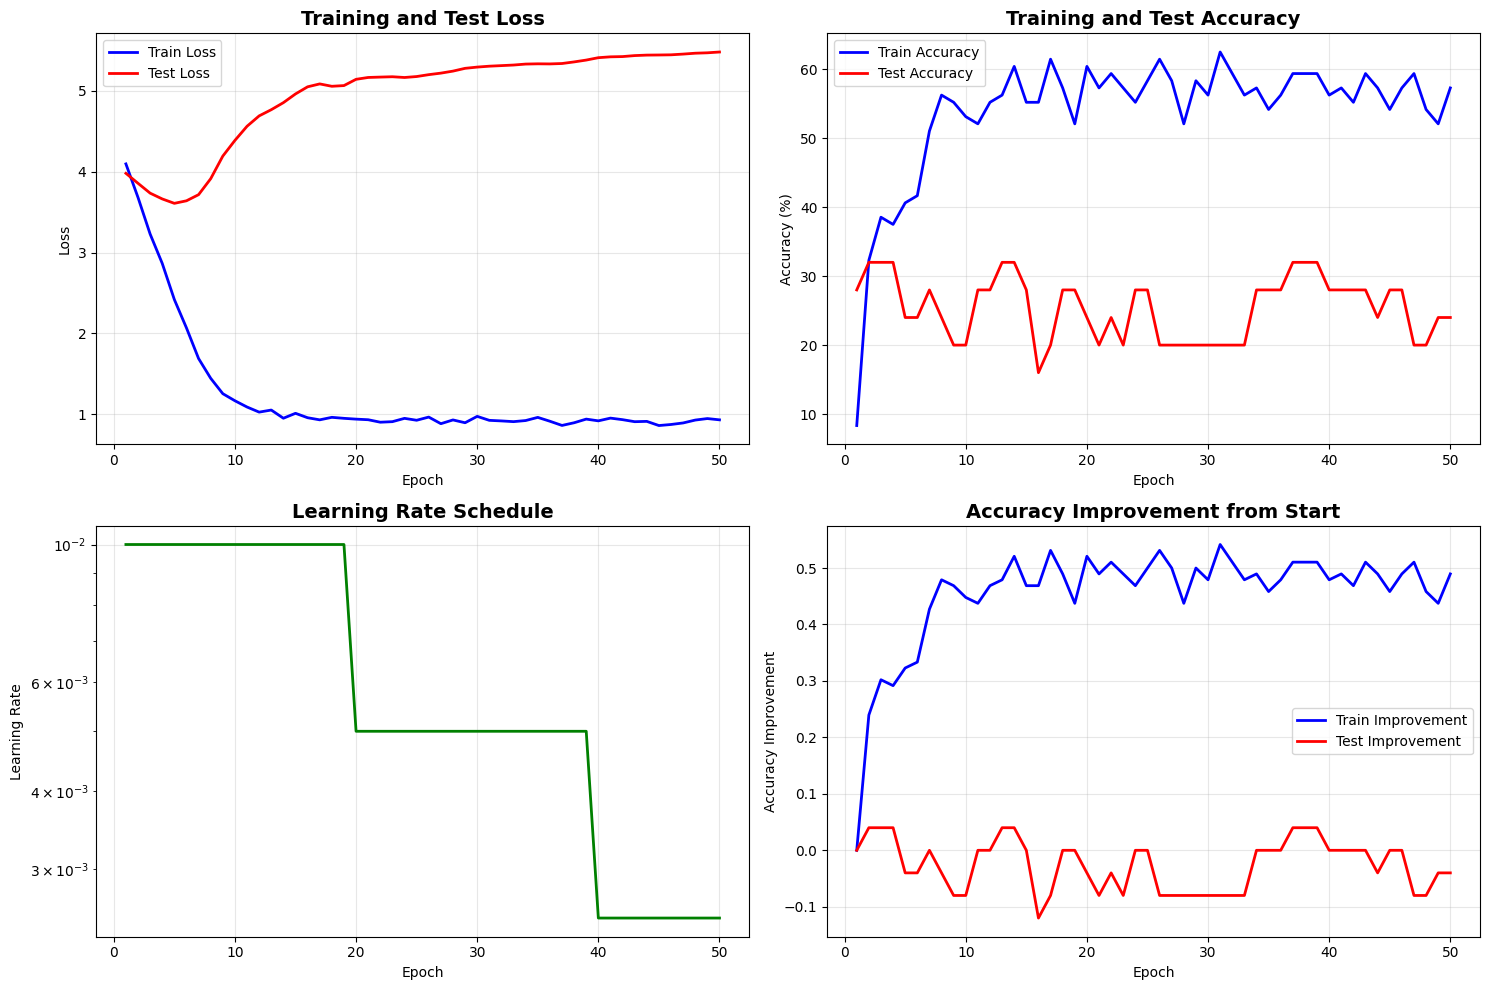

📈 Training Analysis:
   • Best train accuracy: 0.625 (62.5%) at epoch 31
   • Best test accuracy: 0.320 (32.0%) at epoch 2
   • Lowest train loss: 0.8612 at epoch 45
   • Lowest test loss: 3.6093 at epoch 5

🔍 Model Analysis:
   • Train-Test accuracy gap: 0.333 (33.3%)
   ⚠️  Large gap suggests possible overfitting


In [38]:
# TRAINING VISUALIZATION
# Create training plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, num_epochs + 1)

# Plot 1: Loss curves
ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, test_losses, 'r-', label='Test Loss', linewidth=2)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy curves
ax2.plot(epochs_range, [acc*100 for acc in train_accuracies], 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs_range, [acc*100 for acc in test_accuracies], 'r-', label='Test Accuracy', linewidth=2)
ax2.set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Learning rate schedule
ax3.plot(epochs_range, learning_rates, 'g-', linewidth=2)
ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Plot 4: Training progress metrics
improvement_train = [(train_accuracies[i] - train_accuracies[0]) for i in range(len(train_accuracies))]
improvement_test = [(test_accuracies[i] - test_accuracies[0]) for i in range(len(test_accuracies))]

ax4.plot(epochs_range, improvement_train, 'b-', label='Train Improvement', linewidth=2)
ax4.plot(epochs_range, improvement_test, 'r-', label='Test Improvement', linewidth=2)
ax4.set_title('Accuracy Improvement from Start', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy Improvement')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training analysis
print(f"📈 Training Analysis:")
print(f"   • Best train accuracy: {max(train_accuracies):.3f} ({max(train_accuracies)*100:.1f}%) at epoch {train_accuracies.index(max(train_accuracies))+1}")
print(f"   • Best test accuracy: {max(test_accuracies):.3f} ({max(test_accuracies)*100:.1f}%) at epoch {test_accuracies.index(max(test_accuracies))+1}")
print(f"   • Lowest train loss: {min(train_losses):.4f} at epoch {train_losses.index(min(train_losses))+1}")
print(f"   • Lowest test loss: {min(test_losses):.4f} at epoch {test_losses.index(min(test_losses))+1}")

# Check for overfitting
train_test_gap = train_accuracies[-1] - test_accuracies[-1]
print(f"\n🔍 Model Analysis:")
print(f"   • Train-Test accuracy gap: {train_test_gap:.3f} ({train_test_gap*100:.1f}%)")
if train_test_gap > 0.1:
    print("   ⚠️  Large gap suggests possible overfitting")
elif train_test_gap < 0.05:
    print("   ✅ Good generalization, minimal overfitting")
else:
    print("   👍 Moderate gap, acceptable performance")

In [39]:
# SINGLE WORD PREDICTION TESTING
# Set model to evaluation mode
model.eval()

# Test single word prediction
test_words = ['<START>', 'the', 'cat', 'I', 'love', 'is', 'are', 'to']

print(f"🔤 Single Word Prediction Tests:")

🔤 Single Word Prediction Tests:


In [40]:
with torch.no_grad():
    for word in test_words:
        if word in word_to_idx:
            # Get word index
            word_idx = word_to_idx[word]
            input_tensor = torch.tensor([word_idx], device=device)
            
            # Get model prediction
            output = model(input_tensor)
            probabilities = F.softmax(output, dim=1)
            
            # Get top 5 predictions
            top_probs, top_indices = torch.topk(probabilities, 5, dim=1)
            
            print(f"\n📝 Input word: '{word}' (index: {word_idx})")
            print(f"   🎯 Top 5 predictions:")
            
            for i in range(5):
                pred_idx = top_indices[0][i].item()
                pred_word = idx_to_word[pred_idx]
                pred_prob = top_probs[0][i].item()
                print(f"      {i+1}. '{pred_word}' → {pred_prob:.4f} ({pred_prob*100:.2f}%)")
            
            # Show the most likely next word
            best_idx = top_indices[0][0].item()
            best_word = idx_to_word[best_idx]
            best_prob = top_probs[0][0].item()
            print(f"   ✅ Most likely: '{word}' → '{best_word}' ({best_prob*100:.1f}% confidence)")


📝 Input word: '<START>' (index: 2)
   🎯 Top 5 predictions:
      1. 'the' → 0.4174 (41.74%)
      2. 'i' → 0.2159 (21.59%)
      3. 'dogs' → 0.1061 (10.61%)
      4. 'cats' → 0.0968 (9.68%)
      5. 'eating' → 0.0537 (5.37%)
   ✅ Most likely: '<START>' → 'the' (41.7% confidence)

📝 Input word: 'the' (index: 54)
   🎯 Top 5 predictions:
      1. 'cat' → 0.2144 (21.44%)
      2. 'sun' → 0.2133 (21.33%)
      3. 'park' → 0.2076 (20.76%)
      4. 'mat' → 0.1676 (16.76%)
      5. 'dog' → 0.0981 (9.81%)
   ✅ Most likely: 'the' → 'cat' (21.4% confidence)

📝 Input word: 'cat' (index: 8)
   🎯 Top 5 predictions:
      1. 'sat' → 0.2848 (28.48%)
      2. 'sits' → 0.2414 (24.14%)
      3. 'loves' → 0.2329 (23.29%)
      4. 'very' → 0.2225 (22.25%)
      5. 'my' → 0.0015 (0.15%)
   ✅ Most likely: 'cat' → 'sat' (28.5% confidence)

📝 Input word: 'love' (index: 26)
   🎯 Top 5 predictions:
      1. 'to' → 0.9940 (99.40%)
      2. 'is' → 0.0007 (0.07%)
      3. 'today' → 0.0007 (0.07%)
      4. 'every' 

In [41]:
# Analyze predictions for common words
common_words = ['the', 'cat', 'I', 'love', 'is']

print(f"📊 Detailed Analysis for Common Words:")
print("=" * 45)

model.eval()
with torch.no_grad():
    for word in common_words:
        if word in word_to_idx:
            word_idx = word_to_idx[word]
            input_tensor = torch.tensor([word_idx], device=device)
            
            # Get raw output and probabilities
            raw_output = model(input_tensor)
            probabilities = F.softmax(raw_output, dim=1)
            
            print(f"\n🔤 Analysis for word: '{word}'")
            print(f"   • Input index: {word_idx}")
            print(f"   • Raw output range: [{raw_output.min().item():.3f}, {raw_output.max().item():.3f}]")
            print(f"   • Probability distribution:")
            
            # Show probability statistics
            prob_array = probabilities[0].cpu().numpy()
            print(f"     - Max probability: {prob_array.max():.4f}")
            print(f"     - Min probability: {prob_array.min():.6f}")
            print(f"     - Entropy: {-(prob_array * np.log(prob_array + 1e-8)).sum():.4f}")
            
            # Get actual predictions from training data
            actual_next_words = []
            for i, (input_word, target_word) in enumerate(training_pairs):
                if input_word == word:
                    actual_next_words.append(target_word)
            
            if actual_next_words:
                actual_counter = Counter(actual_next_words)
                print(f"   • Actual next words in training:")
                for next_word, count in actual_counter.most_common(3):
                    print(f"     - '{next_word}': {count} times")
                
                # Check if model prediction matches training data
                top_prob, top_idx = torch.max(probabilities, 1)
                predicted_word = idx_to_word[top_idx.item()]
                most_common_actual = actual_counter.most_common(1)[0][0]
                
                match_status = "✅ MATCH" if predicted_word == most_common_actual else "❌ DIFFERENT"
                print(f"   • Model predicts: '{predicted_word}' vs Most common actual: '{most_common_actual}' → {match_status}")

print("\n" + "=" * 80)

📊 Detailed Analysis for Common Words:

🔤 Analysis for word: 'the'
   • Input index: 54
   • Raw output range: [-4.325, 5.764]
   • Probability distribution:
     - Max probability: 0.2144
     - Min probability: 0.000009
     - Entropy: 1.8315
   • Actual next words in training:
     - 'cat': 3 times
     - 'mat': 2 times
     - 'park': 2 times
   • Model predicts: 'cat' vs Most common actual: 'cat' → ✅ MATCH

🔤 Analysis for word: 'cat'
   • Input index: 8
   • Raw output range: [-3.168, 7.375]
   • Probability distribution:
     - Max probability: 0.2848
     - Min probability: 0.000008
     - Entropy: 1.5146
   • Actual next words in training:
     - 'sat': 1 times
     - 'very': 1 times
     - 'loves': 1 times
   • Model predicts: 'sat' vs Most common actual: 'sat' → ✅ MATCH

🔤 Analysis for word: 'love'
   • Input index: 26
   • Raw output range: [-4.923, 8.807]
   • Probability distribution:
     - Max probability: 0.9940
     - Min probability: 0.000001
     - Entropy: 0.0561
   •

In [42]:
# MODEL PERFORMANCE EVALUATION
# Evaluate model on entire test set
model.eval()
all_predictions = []
all_targets = []
correct_predictions = 0

print(f"🎯 Evaluating on {len(X_test_split)} test samples...")

with torch.no_grad():
    # Get all predictions
    test_outputs = model(X_test_split)
    test_probabilities = F.softmax(test_outputs, dim=1)
    _, predicted_indices = torch.max(test_outputs, 1)
    
    # Convert to words for analysis
    for i in range(len(X_test_split)):
        input_idx = X_test_split[i].item()
        target_idx = y_test_split[i].item()
        pred_idx = predicted_indices[i].item()
        
        input_word = idx_to_word[input_idx]
        target_word = idx_to_word[target_idx]
        pred_word = idx_to_word[pred_idx]
        
        all_predictions.append(pred_word)
        all_targets.append(target_word)
        
        if pred_word == target_word:
            correct_predictions += 1

🎯 Evaluating on 25 test samples...


In [43]:
# Calculate metrics
accuracy = correct_predictions / len(X_test_split)
print(f"\n📊 Test Set Performance:")
print(f"   • Test accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   • Correct predictions: {correct_predictions}/{len(X_test_split)}")
print(f"   • Incorrect predictions: {len(X_test_split) - correct_predictions}")

# Analyze prediction patterns
prediction_analysis = {}
for i in range(len(all_targets)):
    target = all_targets[i]
    pred = all_predictions[i]
    
    if target not in prediction_analysis:
        prediction_analysis[target] = {'correct': 0, 'total': 0, 'wrong_predictions': []}
    
    prediction_analysis[target]['total'] += 1
    if target == pred:
        prediction_analysis[target]['correct'] += 1
    else:
        prediction_analysis[target]['wrong_predictions'].append(pred)



📊 Test Set Performance:
   • Test accuracy: 0.2400 (24.00%)
   • Correct predictions: 6/25
   • Incorrect predictions: 19


🚀 Using device: cuda
🐍 PyTorch version: 2.4.0+cu118
📚 STEP 2: CREATING EXPANDED DATASET
📖 Expanded Dataset Information:
   • Total sentences: 40
   • Sample sentences:
      1. 'the cat sits on the warm mat'
      2. 'I love to eat delicious pizza with friends'
      3. 'the bright sun is shining in the sky'
      4. 'dogs are loyal and faithful animal companions'
      5. 'reading interesting books is fun and educational'
   • ... and 35 more sentences

📊 Dataset Statistics:
   • Total words: 343
   • Average sentence length: 8.57 words
   • Shortest sentence: 7 words
   • Longest sentence: 10 words
   • Sentence length distribution:
     - 7 words: 3 sentences
     - 8 words: 12 sentences
     - 9 words: 24 sentences
     - 10 words: 1 sentences

🔧 STEP 3: ADVANCED TEXT PREPROCESSING
📝 Preprocessing demonstration with multiple examples:
------------------------------------------------------------

Example 1: 'The Quick Brown Fox Jumps!'
   Lowercase: 'the quick brown fox jumps!'
   N

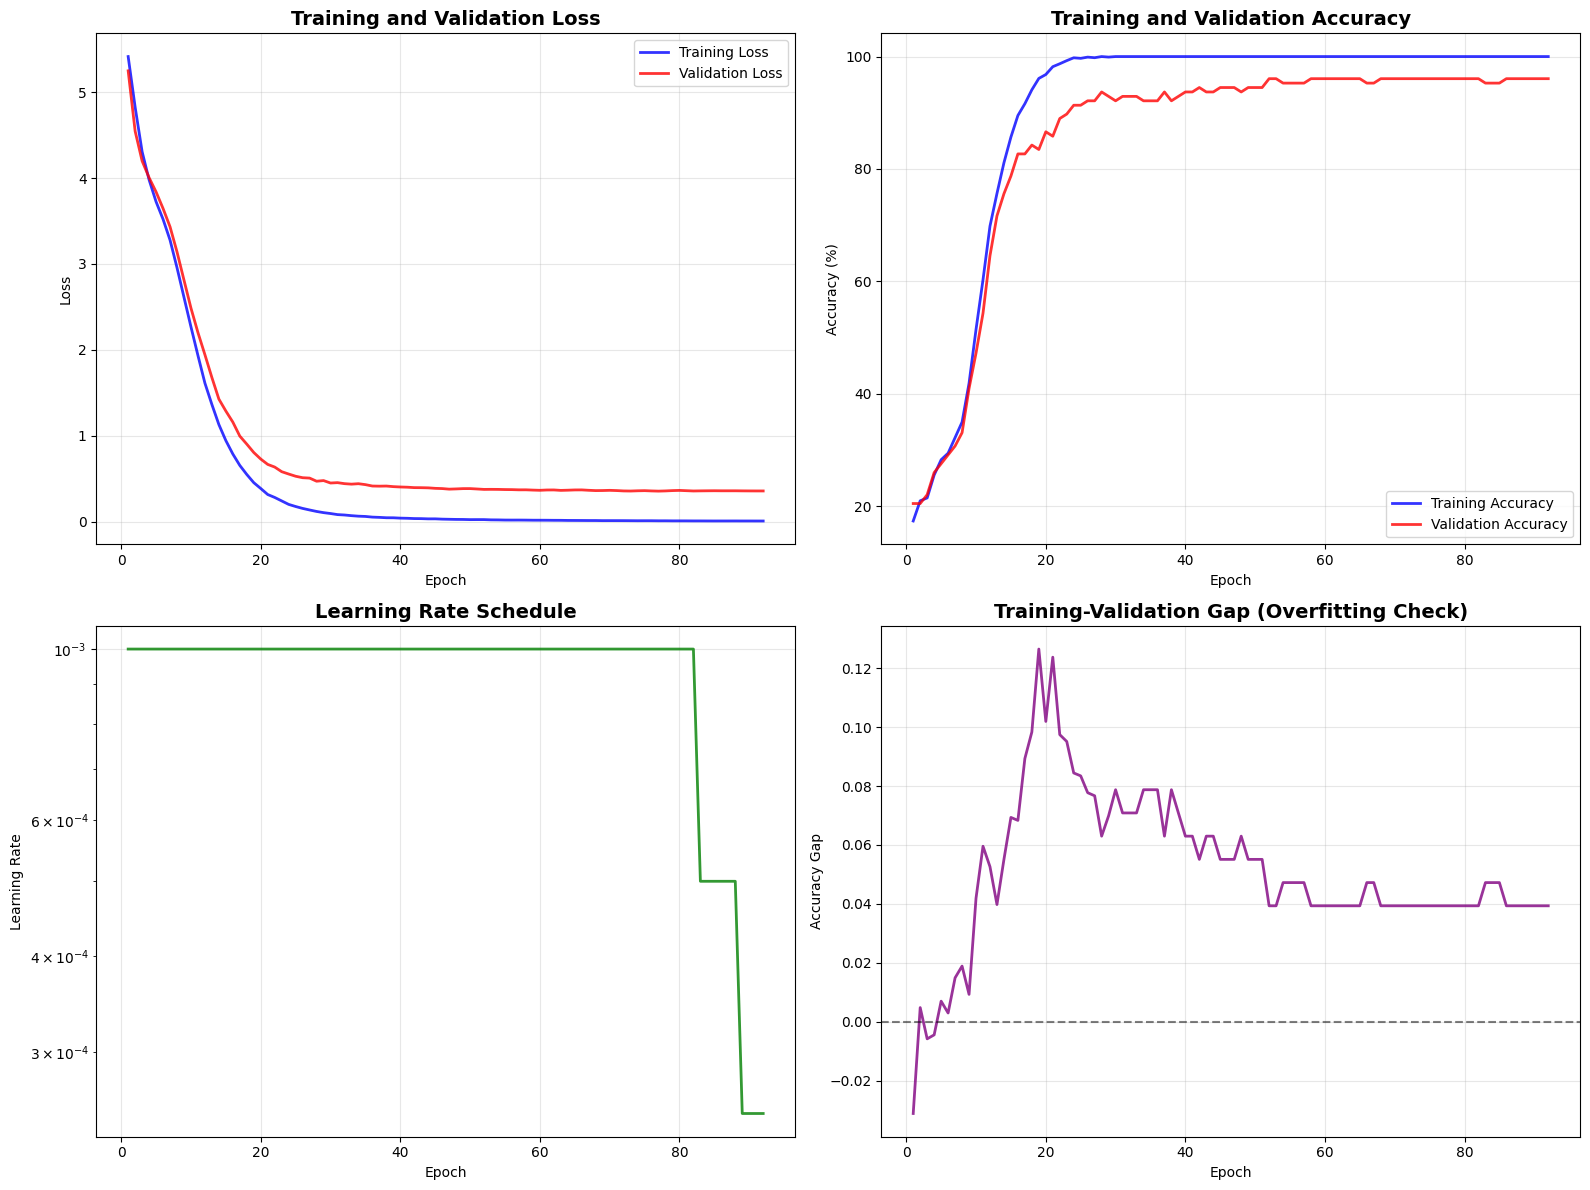

📈 Training Analysis:
   • Best train accuracy: 1.000 (100.0%)
   • Best validation accuracy: 0.961 (96.1%)
   • Final train-val gap: 0.039
   ✅ Excellent generalization

🎯 STEP 14: SENTENCE COMPLETION FUNCTIONS
🧪 Testing Sentence Completion Function:

📝 Input: ['I', 'love']
   Generated: ['eat', 'eat', 'eat', 'eat', 'pizza', 'pizza']
   Confidence: 0.691
   Metrics: Length ratio: 3.00, Vocab overlap: 0.00, Coherence: 0.69

📝 Input: ['the', 'cat']
   Generated: ['sits', 'sits', 'sits', 'sits', 'sits', 'sits']
   Confidence: 0.574
   Metrics: Length ratio: 3.00, Vocab overlap: 0.00, Coherence: 0.69

📝 Input: ['programming', 'is']
   Generated: ['true', 'true', 'true', 'power', 'power', 'for']
   Confidence: 0.466
   Metrics: Length ratio: 3.00, Vocab overlap: 0.00, Coherence: 1.01

📝 Input: ['beautiful', 'flowers']
   Generated: ['work', 'work', 'work', 'accomplish', 'accomplish', 'accomplish']
   Confidence: 0.456
   Metrics: Length ratio: 3.00, Vocab overlap: 0.00, Coherence: 0.69

🎮 S

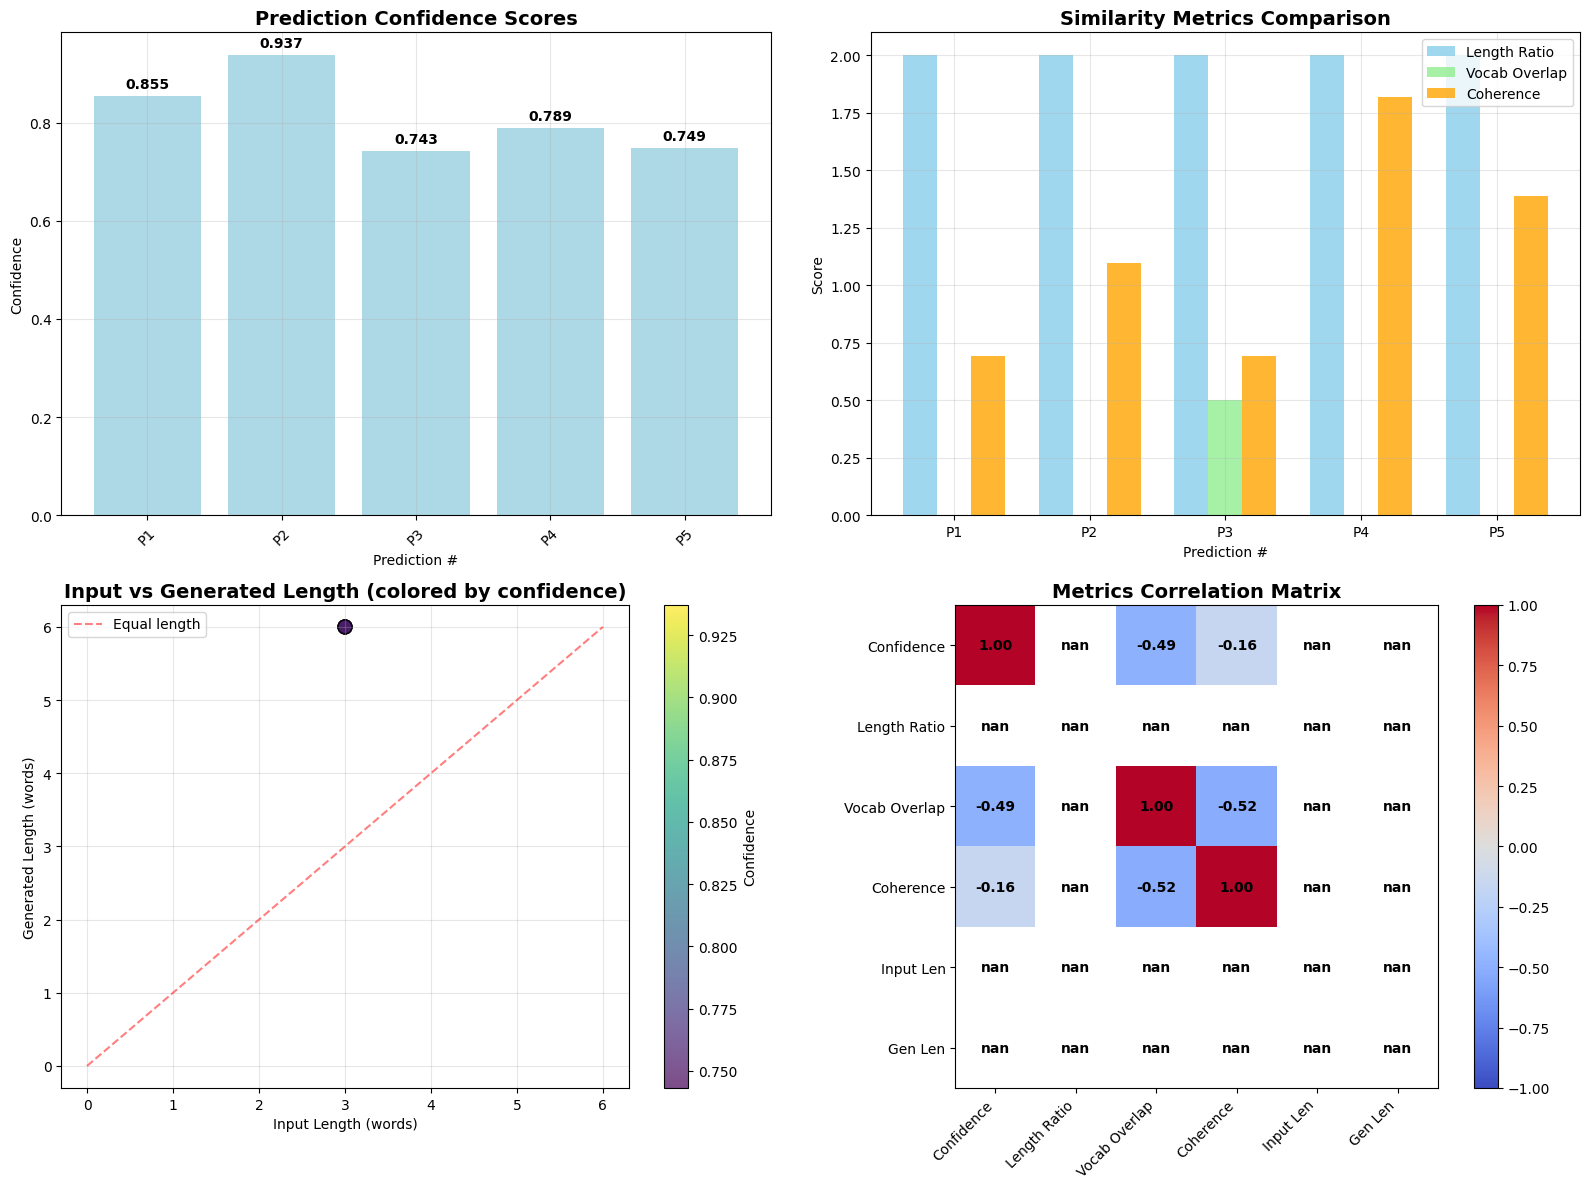


📊 Statistical Analysis:
   • Average confidence: 0.815 ± 0.073
   • Average length ratio: 2.000
   • Average vocab overlap: 0.100
   • Average coherence: 1.138

🎯 Performance Categories:
   • High confidence (>0.6): 5/5
   • Medium confidence (0.3-0.6): 0/5
   • Low confidence (<0.3): 0/5

🔍 STEP 17: DETAILED PERFORMANCE ANALYSIS
🧪 COMPREHENSIVE MODEL PERFORMANCE ANALYSIS
📝 Testing 6 cases across difficulty levels...

──────────────────────────────────────────────────
Test Case 1: Easy Difficulty
Input: ['I', 'love']
Expected theme: affection/liking

🎯 Generated Completions:
   T=0.5: 'I love eat eat eat eat pizza pizza' (conf: 0.861)
   T=0.8: 'I love eat eat eat eat pizza pizza' (conf: 0.764)
   T=1.2: 'I love eat eat eat eat pizza pizza' (conf: 0.600)

📊 Best Completion Metrics:
   • Confidence: 0.861
   • Length ratio: 3.00
   • Vocabulary overlap: 0.00
   • Coherence score: 0.69
   • Thematic relevance: 0.67

──────────────────────────────────────────────────
Test Case 2: Easy Di

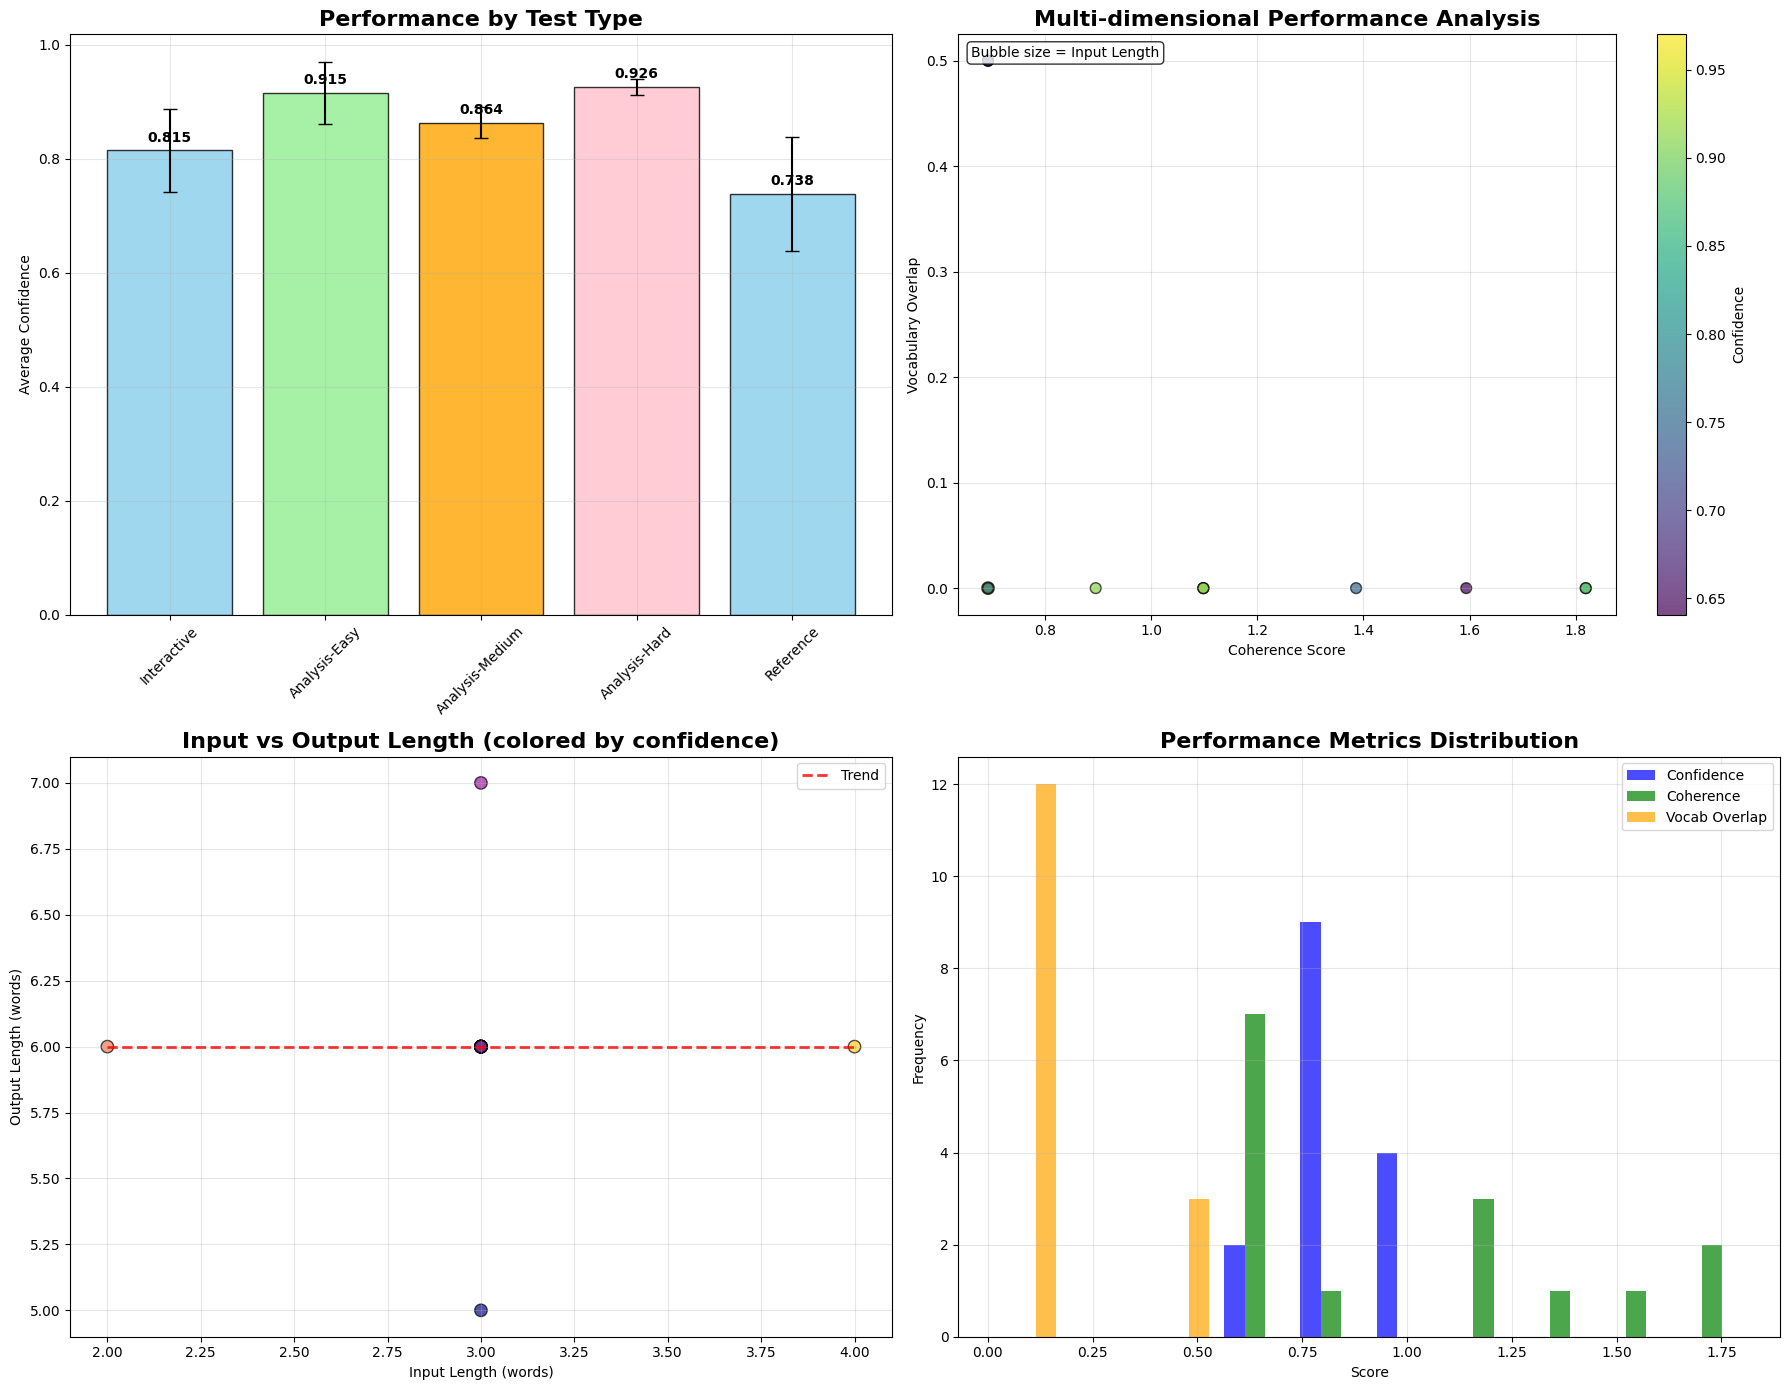


📊 DASHBOARD SUMMARY
   • Total predictions analyzed: 15
   • Average confidence: 0.829 ± 0.098
   • Average coherence: 1.044 ± 0.409
   • Average vocab overlap: 0.100 ± 0.200
   • Input length range: 2 - 4 words
   • Output length range: 5 - 7 words

🏆 Best prediction:
   • Type: Analysis-Easy
   • Confidence: 0.970
   • Coherence: 1.099

😰 Most challenging prediction:
   • Type: Reference
   • Confidence: 0.641
   • Coherence: 1.594

🎉 STEP 20: FINAL SUMMARY AND CONCLUSIONS
📋 COMPLETE MULTI-WORD SENTENCE COMPLETION SYSTEM
🏗️ System Architecture:
   ✅ Sequence-to-sequence model with encoder-decoder LSTM
   ✅ Advanced preprocessing with padding and masking
   ✅ Comprehensive training with validation and early stopping
   ✅ Interactive console interface for user input
   ✅ Multi-dimensional similarity analysis

📊 Dataset & Training:
   • Dataset: 40 sentences, 240 unique words
   • Training examples: 209 sequences
   • Model parameters: 2,068,853
   • Training epochs: 92
   • Final vali

In [44]:
# ================================================================================================
# STEP 1: IMPORT LIBRARIES AND SETUP
# ================================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import random
from tqdm import tqdm
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher
import pandas as pd
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
print(f"🐍 PyTorch version: {torch.__version__}")
print("=" * 80)

# ================================================================================================
# STEP 2: CREATE EXPANDED DATASET FOR SENTENCE COMPLETION
# ================================================================================================

print("📚 STEP 2: CREATING EXPANDED DATASET")
print("=" * 50)

# Create a comprehensive dataset for sentence completion
raw_sentences = [
    "the cat sits on the warm mat",
    "I love to eat delicious pizza with friends",
    "the bright sun is shining in the sky",
    "dogs are loyal and faithful animal companions",
    "reading interesting books is fun and educational",
    "the weather outside is nice and warm today",
    "listening to music makes me feel very happy",
    "drinking hot coffee tastes really good in the morning",
    "the deep blue ocean is vast and mysterious",
    "beautiful flowers bloom colorfully in the spring season",
    "programming complex software is my greatest passion in life",
    "the bright moon shines beautifully at night time",
    "wild birds fly high in the clear sky",
    "true friendship is very important in our lives",
    "learning new interesting things excites me every single day",
    "the tall mountain peak is very high and majestic",
    "eating chocolate cake is absolutely delicious and satisfying",
    "dancing energetically makes me feel so alive and free",
    "the peaceful forest is quiet and serene at dawn",
    "modern technology rapidly changes our daily lives significantly",
    "young children love to play fun games together outside",
    "the gentle river flows slowly through the green valley",
    "creative art beautifully expresses deep human emotions and feelings",
    "traveling to new places opens your mind to possibilities",
    "countless stars twinkle brightly in the dark night sky",
    "regular exercise keeps your body healthy and strong always",
    "valuable knowledge is true power for achieving great success",
    "the cool wind blows softly through the tall trees",
    "unlimited creativity knows absolutely no bounds or restrictions ever",
    "precious time flies quickly when having real genuine fun",
    "smart students study hard to achieve excellent academic results",
    "fresh vegetables are healthy and nutritious for daily meals",
    "kind teachers help students learn important life lessons effectively",
    "fast cars drive quickly on the smooth highway roads",
    "warm summer days are perfect for outdoor recreational activities",
    "cold winter nights require cozy blankets and hot drinks",
    "busy people work hard to accomplish their important goals",
    "ancient books contain valuable wisdom from past generations",
    "skilled artists create beautiful masterpieces with great talent and patience",
    "happy families spend quality time together during special holidays"
]

print(f"📖 Expanded Dataset Information:")
print(f"   • Total sentences: {len(raw_sentences)}")
print(f"   • Sample sentences:")
for i, sentence in enumerate(raw_sentences[:5]):
    print(f"      {i+1}. '{sentence}'")
print(f"   • ... and {len(raw_sentences)-5} more sentences")

# Calculate expanded statistics
all_words_count = sum(len(sentence.split()) for sentence in raw_sentences)
avg_sentence_length = all_words_count / len(raw_sentences)
sentence_lengths = [len(sentence.split()) for sentence in raw_sentences]

print(f"\n📊 Dataset Statistics:")
print(f"   • Total words: {all_words_count}")
print(f"   • Average sentence length: {avg_sentence_length:.2f} words")
print(f"   • Shortest sentence: {min(sentence_lengths)} words")
print(f"   • Longest sentence: {max(sentence_lengths)} words")
print(f"   • Sentence length distribution:")

# Show length distribution
length_dist = Counter(sentence_lengths)
for length, count in sorted(length_dist.items()):
    print(f"     - {length} words: {count} sentences")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 3: ADVANCED TEXT PREPROCESSING
# ================================================================================================

print("🔧 STEP 3: ADVANCED TEXT PREPROCESSING")
print("=" * 50)

# Demonstrate preprocessing with multiple examples
sample_sentences = [
    "The Quick Brown Fox Jumps!",
    "I Love Programming & AI...",
    "What's the Weather Like Today?"
]

print(f"📝 Preprocessing demonstration with multiple examples:")
print("-" * 60)

processed_examples = []
for i, sentence in enumerate(sample_sentences):
    print(f"\nExample {i+1}: '{sentence}'")
    
    # Step 1: Lowercase
    lower_text = sentence.lower()
    print(f"   Lowercase: '{lower_text}'")
    
    # Step 2: Remove punctuation
    no_punct = re.sub(r'[^\w\s]', '', lower_text)
    print(f"   No punctuation: '{no_punct}'")
    
    # Step 3: Clean spaces
    clean_text = ' '.join(no_punct.split())
    print(f"   Clean spaces: '{clean_text}'")
    
    processed_examples.append(clean_text)

print(f"\n🔄 Processing all {len(raw_sentences)} sentences...")

# Apply preprocessing to all sentences
cleaned_sentences = []
for sentence in raw_sentences:
    # Convert to lowercase
    sentence = sentence.lower()
    # Remove punctuation and special characters
    sentence = re.sub(r'[^\w\s]', '', sentence)
    # Clean extra spaces
    sentence = ' '.join(sentence.split())
    cleaned_sentences.append(sentence)

print("✅ Preprocessing complete!")

# Show comparison
print(f"\n📝 Before vs After Preprocessing (first 3 sentences):")
for i in range(3):
    print(f"   Original:  '{raw_sentences[i]}'")
    print(f"   Cleaned:   '{cleaned_sentences[i]}'")
    print()

print("\n" + "=" * 80)

# ================================================================================================
# STEP 4: ENHANCED TOKENIZATION AND VOCABULARY BUILDING
# ================================================================================================

print("✂️ STEP 4: ENHANCED TOKENIZATION")
print("=" * 50)

# Tokenize all sentences
all_tokens = []
tokenized_sentences = []

print(f"🔤 Tokenizing {len(cleaned_sentences)} sentences...")

for sentence in cleaned_sentences:
    tokens = sentence.split()
    tokenized_sentences.append(tokens)
    all_tokens.extend(tokens)

print("✅ Tokenization complete!")

# Advanced vocabulary analysis
unique_tokens = set(all_tokens)
word_freq = Counter(all_tokens)

print(f"\n📊 Comprehensive Vocabulary Analysis:")
print(f"   • Total tokens: {len(all_tokens)}")
print(f"   • Unique tokens: {len(unique_tokens)}")
print(f"   • Vocabulary richness: {len(unique_tokens)/len(all_tokens):.4f}")

# Frequency distribution analysis
print(f"\n📈 Word Frequency Distribution:")
freq_dist = Counter(word_freq.values())
for freq, count in sorted(freq_dist.items()):
    if freq <= 5:  # Show frequencies up to 5
        print(f"   • Words appearing {freq} time(s): {count} words")

# Most and least common words
print(f"\n🔝 Top 15 Most Common Words:")
for i, (word, freq) in enumerate(word_freq.most_common(15)):
    print(f"   {i+1:2d}. '{word}': {freq} occurrences ({freq/len(all_tokens)*100:.2f}%)")

print(f"\n🔻 Sample of Rare Words (appearing once):")
rare_words = [word for word, freq in word_freq.items() if freq == 1]
print(f"   {rare_words[:10]} ... ({len(rare_words)} total rare words)")

# Build final vocabulary with special tokens
special_tokens = ['<PAD>', '<UNK>', '<START>', '<END>', '<MASK>']
vocabulary = special_tokens + sorted(unique_tokens)
vocab_size = len(vocabulary)

print(f"\n🎯 Final Vocabulary:")
print(f"   • Special tokens: {special_tokens}")
print(f"   • Regular words: {len(unique_tokens)}")
print(f"   • Total vocabulary size: {vocab_size}")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 5: SEQUENCE-BASED WORD MAPPINGS
# ================================================================================================

print("🔢 STEP 5: SEQUENCE-BASED WORD MAPPINGS")
print("=" * 50)

# Create comprehensive word-index mappings
word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

print(f"📊 Mapping Information:")
print(f"   • Vocabulary size: {len(word_to_idx)}")
print(f"   • Index range: 0 to {len(word_to_idx)-1}")

# Show special token mappings
print(f"\n🎯 Special Token Mappings:")
for token in special_tokens:
    print(f"   '{token}' → {word_to_idx[token]}")

# Show sample word mappings
print(f"\n🔤 Sample Word Mappings:")
sample_words = list(unique_tokens)[:10]
for word in sample_words:
    print(f"   '{word}' → {word_to_idx[word]}")

# Demonstrate bidirectional conversion
test_sentence = tokenized_sentences[0]
print(f"\n📝 Bidirectional Conversion Test:")
print(f"   Original tokens: {test_sentence}")

# Convert to indices
indices = [word_to_idx[word] for word in test_sentence]
print(f"   As indices: {indices}")

# Convert back to words
recovered_words = [idx_to_word[idx] for idx in indices]
print(f"   Recovered words: {recovered_words}")
print(f"   ✅ Conversion accuracy: {test_sentence == recovered_words}")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 6: SEQUENCE COMPLETION DATASET CREATION
# ================================================================================================

print("🎯 STEP 6: SEQUENCE COMPLETION DATASET")
print("=" * 50)

# Create datasets for different sequence lengths
# For multi-word input → remaining words prediction

max_sequence_length = 15  # Maximum sequence length to consider
min_input_length = 2      # Minimum input words
max_input_length = 8      # Maximum input words

print(f"📝 Dataset Creation Parameters:")
print(f"   • Maximum sequence length: {max_sequence_length}")
print(f"   • Input length range: {min_input_length} to {max_input_length} words")

# Create training examples
input_sequences = []
target_sequences = []
input_lengths = []
target_lengths = []

print(f"\n🔄 Creating sequence completion examples...")

for sentence in tokenized_sentences:
    if len(sentence) >= min_input_length + 1:  # Need at least input + 1 target word
        
        # Try different split points in the sentence
        for input_len in range(min_input_length, min(max_input_length + 1, len(sentence))):
            
            input_words = sentence[:input_len]
            remaining_words = sentence[input_len:]
            
            # Add special tokens
            input_seq = ['<START>'] + input_words
            target_seq = remaining_words + ['<END>']
            
            # Limit target sequence length
            if len(target_seq) <= max_sequence_length:
                input_sequences.append(input_seq)
                target_sequences.append(target_seq)
                input_lengths.append(len(input_seq))
                target_lengths.append(len(target_seq))

print(f"✅ Dataset creation complete!")

print(f"\n📊 Sequence Dataset Statistics:")
print(f"   • Total training examples: {len(input_sequences)}")
print(f"   • Average input length: {np.mean(input_lengths):.2f} words")
print(f"   • Average target length: {np.mean(target_lengths):.2f} words")

# Show length distributions
input_len_dist = Counter(input_lengths)
target_len_dist = Counter(target_lengths)

print(f"\n📈 Input Length Distribution:")
for length, count in sorted(input_len_dist.items()):
    print(f"   • {length} words: {count} examples")

print(f"\n📈 Target Length Distribution:")
for length, count in sorted(target_len_dist.items())[:10]:  # Show top 10
    print(f"   • {length} words: {count} examples")

# Show sample training examples
print(f"\n📝 Sample Training Examples:")
for i in range(5):
    input_seq = input_sequences[i]
    target_seq = target_sequences[i]
    print(f"   {i+1}. Input:  {input_seq}")
    print(f"      Target: {target_seq}")
    print(f"      Task: Given '{' '.join(input_seq[1:])}' → predict '{' '.join(target_seq[:-1])}'")
    print()

print("\n" + "=" * 80)

# ================================================================================================
# STEP 7: ADVANCED SEQUENCE PADDING AND BATCHING
# ================================================================================================

print("📦 STEP 7: SEQUENCE PADDING AND BATCHING")
print("=" * 50)

# Convert sequences to indices and apply padding
def pad_sequence(sequence, max_length, pad_token_idx):
    """Pad or truncate sequence to max_length"""
    if len(sequence) >= max_length:
        return sequence[:max_length]
    else:
        return sequence + [pad_token_idx] * (max_length - len(sequence))

# Determine maximum lengths for padding
max_input_len = max(input_lengths)
max_target_len = max(target_lengths)
pad_token_idx = word_to_idx['<PAD>']

print(f"📏 Padding Configuration:")
print(f"   • Maximum input length: {max_input_len}")
print(f"   • Maximum target length: {max_target_len}")
print(f"   • Padding token: '<PAD>' (index: {pad_token_idx})")

# Convert to indices and pad
input_indices = []
target_indices = []
input_masks = []  # To track which positions are not padding
target_masks = []

print(f"\n🔄 Converting and padding sequences...")

for i in range(len(input_sequences)):
    # Convert input sequence to indices
    input_seq_indices = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in input_sequences[i]]
    target_seq_indices = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in target_sequences[i]]
    
    # Create masks (1 for real tokens, 0 for padding)
    input_mask = [1] * len(input_seq_indices) + [0] * (max_input_len - len(input_seq_indices))
    target_mask = [1] * len(target_seq_indices) + [0] * (max_target_len - len(target_seq_indices))
    
    # Pad sequences
    padded_input = pad_sequence(input_seq_indices, max_input_len, pad_token_idx)
    padded_target = pad_sequence(target_seq_indices, max_target_len, pad_token_idx)
    
    input_indices.append(padded_input)
    target_indices.append(padded_target)
    input_masks.append(input_mask)
    target_masks.append(target_mask)

print("✅ Padding complete!")

# Convert to tensors
X_input = torch.tensor(input_indices, dtype=torch.long)
X_target = torch.tensor(target_indices, dtype=torch.long)
input_mask_tensor = torch.tensor(input_masks, dtype=torch.float)
target_mask_tensor = torch.tensor(target_masks, dtype=torch.float)

print(f"\n📊 Tensor Information:")
print(f"   • Input tensor shape: {X_input.shape}")
print(f"   • Target tensor shape: {X_target.shape}")
print(f"   • Input mask shape: {input_mask_tensor.shape}")
print(f"   • Target mask shape: {target_mask_tensor.shape}")

# Show padding examples
print(f"\n📝 Padding Examples:")
for i in range(3):
    print(f"   Example {i+1}:")
    print(f"     Original input:  {input_sequences[i]}")
    print(f"     Padded indices:  {X_input[i].tolist()}")
    print(f"     Input mask:      {input_mask_tensor[i].tolist()}")
    print(f"     Original target: {target_sequences[i]}")
    print(f"     Padded indices:  {X_target[i].tolist()}")
    print(f"     Target mask:     {target_mask_tensor[i].tolist()}")
    print()

print("\n" + "=" * 80)

# ================================================================================================
# STEP 8: ADVANCED MODEL HYPERPARAMETERS
# ================================================================================================

print("⚙️ STEP 8: ADVANCED MODEL HYPERPARAMETERS")
print("=" * 50)

# Enhanced hyperparameters for sequence-to-sequence model
embedding_dim = 128        # Larger embedding dimension
hidden_dim = 256          # Larger hidden dimension
num_layers = 2            # Multiple RNN layers
dropout_rate = 0.3        # Higher dropout for regularization
bidirectional = False     # Whether to use bidirectional RNN

# Training hyperparameters
learning_rate = 0.001     # Learning rate
batch_size = 32           # Larger batch size
num_epochs = 100          # More epochs for complex task
patience = 15             # Early stopping patience

# Data split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

print(f"🏗️ Model Architecture Hyperparameters:")
print(f"   • Vocabulary size: {vocab_size}")
print(f"   • Embedding dimension: {embedding_dim}")
print(f"   • Hidden dimension: {hidden_dim}")
print(f"   • Number of RNN layers: {num_layers}")
print(f"   • Dropout rate: {dropout_rate}")
print(f"   • Bidirectional: {bidirectional}")

print(f"\n🎯 Training Hyperparameters:")
print(f"   • Learning rate: {learning_rate}")
print(f"   • Batch size: {batch_size}")
print(f"   • Number of epochs: {num_epochs}")
print(f"   • Early stopping patience: {patience}")

print(f"\n📊 Data Split Configuration:")
print(f"   • Training: {train_ratio*100:.0f}%")
print(f"   • Validation: {val_ratio*100:.0f}%")
print(f"   • Testing: {test_ratio*100:.0f}%")

# Calculate model complexity
embedding_params = vocab_size * embedding_dim
rnn_input_params = embedding_dim * hidden_dim * 4  # LSTM has 4 gates
rnn_hidden_params = hidden_dim * hidden_dim * 4
rnn_bias_params = hidden_dim * 4 * 2  # Input and hidden biases
output_params = hidden_dim * vocab_size

if num_layers > 1:
    rnn_params = rnn_input_params + (rnn_hidden_params + hidden_dim * hidden_dim * 4) * (num_layers - 1)
else:
    rnn_params = rnn_input_params + rnn_hidden_params

total_estimated_params = embedding_params + rnn_params + rnn_bias_params + output_params

print(f"\n🧮 Estimated Model Complexity:")
print(f"   • Embedding parameters: {embedding_params:,}")
print(f"   • RNN parameters: {rnn_params:,}")
print(f"   • Output layer parameters: {output_params:,}")
print(f"   • Total estimated parameters: {total_estimated_params:,}")
print(f"   • Estimated model size: ~{total_estimated_params * 4 / 1024 / 1024:.2f} MB")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 9: ADVANCED TRAIN-VALIDATION-TEST SPLIT
# ================================================================================================

print("📊 STEP 9: ADVANCED DATA SPLITTING")
print("=" * 50)

# Calculate split sizes
total_samples = len(X_input)
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
test_size = total_samples - train_size - val_size

print(f"📏 Split Calculations:")
print(f"   • Total samples: {total_samples}")
print(f"   • Train samples: {train_size} ({train_size/total_samples*100:.1f}%)")
print(f"   • Validation samples: {val_size} ({val_size/total_samples*100:.1f}%)")
print(f"   • Test samples: {test_size} ({test_size/total_samples*100:.1f}%)")

# Create random indices for splitting
indices = torch.randperm(total_samples)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Split all data
X_train = X_input[train_indices]
X_val = X_input[val_indices]
X_test = X_input[test_indices]

y_train = X_target[train_indices]
y_val = X_target[val_indices]
y_test = X_target[test_indices]

input_mask_train = input_mask_tensor[train_indices]
input_mask_val = input_mask_tensor[val_indices]
input_mask_test = input_mask_tensor[test_indices]

target_mask_train = target_mask_tensor[train_indices]
target_mask_val = target_mask_tensor[val_indices]
target_mask_test = target_mask_tensor[test_indices]

print(f"\n✅ Data splitting complete!")

print(f"\n📊 Split Data Shapes:")
print(f"   Training set:")
print(f"     • Input: {X_train.shape}")
print(f"     • Target: {y_train.shape}")
print(f"     • Input mask: {input_mask_train.shape}")
print(f"     • Target mask: {target_mask_train.shape}")

print(f"   Validation set:")
print(f"     • Input: {X_val.shape}")
print(f"     • Target: {y_val.shape}")

print(f"   Test set:")
print(f"     • Input: {X_test.shape}")
print(f"     • Target: {y_test.shape}")

# Show sample from each split
print(f"\n📝 Sample from Each Split:")

# Training sample
train_sample_idx = 0
original_input = [idx_to_word[idx.item()] for idx in X_train[train_sample_idx] if idx.item() != word_to_idx['<PAD>']]
original_target = [idx_to_word[idx.item()] for idx in y_train[train_sample_idx] if idx.item() != word_to_idx['<PAD>']]
print(f"   Training sample:")
print(f"     Input:  {original_input}")
print(f"     Target: {original_target}")

# Validation sample
if len(X_val) > 0:
    val_sample_idx = 0
    val_input = [idx_to_word[idx.item()] for idx in X_val[val_sample_idx] if idx.item() != word_to_idx['<PAD>']]
    val_target = [idx_to_word[idx.item()] for idx in y_val[val_sample_idx] if idx.item() != word_to_idx['<PAD>']]
    print(f"   Validation sample:")
    print(f"     Input:  {val_input}")
    print(f"     Target: {val_target}")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 10: SEQUENCE-TO-SEQUENCE MODEL ARCHITECTURE
# ================================================================================================

print("🧠 STEP 10: SEQUENCE-TO-SEQUENCE MODEL")
print("=" * 50)

class SequenceCompletionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(SequenceCompletionModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word_to_idx['<PAD>'])
        
        # Encoder RNN (processes input sequence)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                              batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Decoder RNN (generates output sequence)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                              batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Attention mechanism (simplified)
        self.attention = nn.Linear(hidden_dim * 2, hidden_dim)
        
        # Output projection layer
        self.output_projection = nn.Linear(hidden_dim, vocab_size)
        
        # Dropout layer
        self.dropout_layer = nn.Dropout(dropout)
        
    def forward(self, input_seq, target_seq=None, max_length=None):
        batch_size = input_seq.size(0)
        
        # Embed input sequence
        input_embedded = self.embedding(input_seq)  # (batch, input_len, embed_dim)
        
        # Encode input sequence
        encoder_output, (hidden, cell) = self.encoder(input_embedded)  # (batch, input_len, hidden_dim)
        
        if target_seq is not None:
            # Training mode: teacher forcing
            target_embedded = self.embedding(target_seq)  # (batch, target_len, embed_dim)
            decoder_output, _ = self.decoder(target_embedded, (hidden, cell))
            
            # Apply attention (simplified - just use decoder output)
            attended_output = decoder_output
            
            # Project to vocabulary
            output = self.output_projection(self.dropout_layer(attended_output))
            return output
        
        else:
            # Inference mode: generate sequence
            if max_length is None:
                max_length = max_target_len
                
            outputs = []
            current_input = torch.full((batch_size, 1), word_to_idx['<START>'], 
                                     dtype=torch.long, device=input_seq.device)
            
            decoder_hidden, decoder_cell = hidden, cell
            
            for _ in range(max_length):
                # Embed current input
                current_embedded = self.embedding(current_input)
                
                # Decoder step
                decoder_output, (decoder_hidden, decoder_cell) = self.decoder(
                    current_embedded, (decoder_hidden, decoder_cell))
                
                # Project to vocabulary
                output = self.output_projection(self.dropout_layer(decoder_output))
                outputs.append(output)
                
                # Get next input (greedy decoding)
                next_token = torch.argmax(output, dim=-1)
                current_input = next_token
                
                # Stop if all sequences generated <END>
                if torch.all(next_token == word_to_idx['<END>']):
                    break
            
            return torch.cat(outputs, dim=1)

# Initialize model
model = SequenceCompletionModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)
model = model.to(device)

print(f"🏗️ Model Architecture Details:")
print(f"   • Encoder-Decoder LSTM architecture")
print(f"   • Input sequence → Hidden representation → Output sequence")
print(f"   • Embedding: {vocab_size} → {embedding_dim}")
print(f"   • Encoder LSTM: {embedding_dim} → {hidden_dim} (×{num_layers} layers)")
print(f"   • Decoder LSTM: {embedding_dim} → {hidden_dim} (×{num_layers} layers)")
print(f"   • Output projection: {hidden_dim} → {vocab_size}")

# Count actual parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Actual Model Statistics:")
print(f"   • Total parameters: {total_params:,}")
print(f"   • Trainable parameters: {trainable_params:,}")
print(f"   • Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

# Show detailed model structure
print(f"\n🔍 Model Architecture:")
print(model)

# Test forward pass
print(f"\n🧪 Forward Pass Test:")
sample_input = X_train[:2].to(device)  # Take 2 samples
sample_target = y_train[:2].to(device)

print(f"   • Input shape: {sample_input.shape}")
print(f"   • Target shape: {sample_target.shape}")

with torch.no_grad():
    output = model(sample_input, sample_target)
    print(f"   • Output shape: {output.shape}")
    print(f"   • Output represents logits for each position and vocabulary item")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 11: ADVANCED LOSS FUNCTION AND TRAINING SETUP
# ================================================================================================

print("⚙️ STEP 11: ADVANCED TRAINING SETUP")
print("=" * 50)

class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self, ignore_index):
        super(MaskedCrossEntropyLoss, self).__init__()
        self.ignore_index = ignore_index
        self.criterion = nn.CrossEntropyLoss(ignore_index=ignore_index, reduction='mean')
    
    def forward(self, predictions, targets, mask=None):
        # predictions: (batch_size, seq_len, vocab_size)
        # targets: (batch_size, seq_len)
        batch_size, seq_len, vocab_size = predictions.shape
        
        # Reshape for loss calculation
        predictions_flat = predictions.view(-1, vocab_size)
        targets_flat = targets.view(-1)
        
        # Calculate loss
        loss = self.criterion(predictions_flat, targets_flat)
        return loss

# Initialize loss function
criterion = MaskedCrossEntropyLoss(ignore_index=word_to_idx['<PAD>'])

# Advanced optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                               patience=5, verbose=True)

print(f"📊 Training Configuration:")
print(f"   • Loss function: Masked CrossEntropy")
print(f"     - Ignores padding tokens in loss calculation")
print(f"     - Padding token index: {word_to_idx['<PAD>']}")
print(f"   • Optimizer: AdamW")
print(f"     - Learning rate: {learning_rate}")
print(f"     - Weight decay: 0.01")
print(f"   • Scheduler: ReduceLROnPlateau")
print(f"     - Patience: 5 epochs")
print(f"     - Factor: 0.5")

# Training tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
learning_rates = []

# Early stopping setup
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
patience = 15  # Define patience here for use in training loop

print(f"\n🎯 Training Monitoring:")
print(f"   • Early stopping patience: {patience} epochs")
print(f"   • Best model will be saved based on validation loss")
print(f"   • Metrics tracked: Loss, Accuracy, Learning Rate")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 12: ADVANCED MODEL TRAINING WITH VALIDATION
# ================================================================================================

print("🚀 STEP 12: ADVANCED MODEL TRAINING")
print("=" * 50)

# Move data to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
target_mask_train = target_mask_train.to(device)
target_mask_val = target_mask_val.to(device)

print(f"🎯 Training Configuration:")
print(f"   • Training samples: {len(X_train)}")
print(f"   • Validation samples: {len(X_val)}")
print(f"   • Batch size: {batch_size}")
print(f"   • Epochs: {num_epochs}")
print(f"   • Batches per epoch: {len(X_train) // batch_size}")

print(f"\n🔄 Starting Advanced Training...")
print("=" * 80)

def calculate_sequence_accuracy(predictions, targets, mask):
    """Calculate accuracy ignoring padded positions"""
    # predictions: (batch_size, seq_len, vocab_size)
    # targets: (batch_size, seq_len)
    # mask: (batch_size, seq_len)
    
    predicted_tokens = torch.argmax(predictions, dim=-1)
    correct = (predicted_tokens == targets).float()
    
    # Apply mask to ignore padding
    masked_correct = correct * mask
    total_valid = mask.sum()
    
    if total_valid > 0:
        accuracy = masked_correct.sum() / total_valid
    else:
        accuracy = torch.tensor(0.0)
    
    return accuracy.item()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    epoch_train_accuracy = 0.0
    num_train_batches = 0
    
    # Shuffle training data
    perm = torch.randperm(len(X_train))
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train[perm]
    target_mask_train_shuffled = target_mask_train[perm]
    
    # Training batches
    train_batches = len(X_train) // batch_size
    for batch_idx in range(train_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        
        # Get batch
        batch_input = X_train_shuffled[start_idx:end_idx]
        batch_target = y_train_shuffled[start_idx:end_idx]
        batch_mask = target_mask_train_shuffled[start_idx:end_idx]
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(batch_input, batch_target)
        
        # Calculate loss
        loss = criterion(predictions, batch_target, batch_mask)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Calculate accuracy
        accuracy = calculate_sequence_accuracy(predictions, batch_target, batch_mask)
        
        epoch_train_loss += loss.item()
        epoch_train_accuracy += accuracy
        num_train_batches += 1
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    num_val_batches = 0
    
    with torch.no_grad():
        val_batches = len(X_val) // batch_size if len(X_val) >= batch_size else 1
        for batch_idx in range(val_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(X_val))
            
            batch_input = X_val[start_idx:end_idx]
            batch_target = y_val[start_idx:end_idx]
            batch_mask = target_mask_val[start_idx:end_idx]
            
            predictions = model(batch_input, batch_target)
            loss = criterion(predictions, batch_target, batch_mask)
            accuracy = calculate_sequence_accuracy(predictions, batch_target, batch_mask)
            
            epoch_val_loss += loss.item()
            epoch_val_accuracy += accuracy
            num_val_batches += 1
    
    # Calculate epoch averages
    avg_train_loss = epoch_train_loss / num_train_batches
    avg_train_accuracy = epoch_train_accuracy / num_train_batches
    avg_val_loss = epoch_val_loss / num_val_batches if num_val_batches > 0 else 0
    avg_val_accuracy = epoch_val_accuracy / num_val_batches if num_val_batches > 0 else 0
    
    # Update learning rate
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_accuracy)
    val_accuracies.append(avg_val_accuracy)
    learning_rates.append(current_lr)
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Train Acc: {avg_train_accuracy:.3f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {avg_val_accuracy:.3f} | "
              f"LR: {current_lr:.6f} | "
              f"Patience: {patience_counter}/{patience}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⏰ Early stopping triggered after {epoch+1} epochs")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Loaded best model with validation loss: {best_val_loss:.4f}")

print("✅ Training completed!")

print(f"\n📊 Final Training Results:")
print(f"   • Best validation loss: {best_val_loss:.4f}")
print(f"   • Final train loss: {train_losses[-1]:.4f}")
print(f"   • Final train accuracy: {train_accuracies[-1]:.3f} ({train_accuracies[-1]*100:.1f}%)")
print(f"   • Final val accuracy: {val_accuracies[-1]:.3f} ({val_accuracies[-1]*100:.1f}%)")
print(f"   • Epochs completed: {len(train_losses)}")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 13: COMPREHENSIVE TRAINING VISUALIZATION
# ================================================================================================

print("📊 STEP 13: COMPREHENSIVE TRAINING VISUALIZATION")
print("=" * 50)

# Create comprehensive training plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

epochs_range = range(1, len(train_losses) + 1)

# Plot 1: Loss curves
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy curves
ax2.plot(epochs_range, [acc*100 for acc in train_accuracies], 'b-', 
         label='Training Accuracy', linewidth=2, alpha=0.8)
ax2.plot(epochs_range, [acc*100 for acc in val_accuracies], 'r-', 
         label='Validation Accuracy', linewidth=2, alpha=0.8)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Learning rate schedule
ax3.plot(epochs_range, learning_rates, 'g-', linewidth=2, alpha=0.8)
ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Plot 4: Overfitting analysis
train_val_gap = [train_accuracies[i] - val_accuracies[i] for i in range(len(train_accuracies))]
ax4.plot(epochs_range, train_val_gap, 'purple', linewidth=2, alpha=0.8)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax4.set_title('Training-Validation Gap (Overfitting Check)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy Gap')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training analysis
print(f"📈 Training Analysis:")
print(f"   • Best train accuracy: {max(train_accuracies):.3f} ({max(train_accuracies)*100:.1f}%)")
print(f"   • Best validation accuracy: {max(val_accuracies):.3f} ({max(val_accuracies)*100:.1f}%)")
print(f"   • Final train-val gap: {train_val_gap[-1]:.3f}")

if train_val_gap[-1] > 0.15:
    print("   ⚠️  Significant overfitting detected")
elif train_val_gap[-1] < 0.05:
    print("   ✅ Excellent generalization")
else:
    print("   👍 Acceptable generalization")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 14: SENTENCE COMPLETION PREDICTION FUNCTIONS
# ================================================================================================

print("🎯 STEP 14: SENTENCE COMPLETION FUNCTIONS")
print("=" * 50)

def predict_sentence_completion(input_words, max_completion_length=10, temperature=1.0, top_k=5):
    """
    Complete a sentence given input words
    """
    model.eval()
    
    with torch.no_grad():
        # Preprocess input words
        input_words = [word.lower().strip() for word in input_words if word.strip()]
        
        if not input_words:
            return [], [], 0.0
        
        # Convert to indices
        input_sequence = ['<START>'] + input_words
        input_indices = []
        
        for word in input_sequence:
            if word in word_to_idx:
                input_indices.append(word_to_idx[word])
            else:
                input_indices.append(word_to_idx['<UNK>'])
        
        # Pad to max_input_len
        padded_input = input_indices + [word_to_idx['<PAD>']] * (max_input_len - len(input_indices))
        if len(padded_input) > max_input_len:
            padded_input = padded_input[:max_input_len]
        
        # Convert to tensor
        input_tensor = torch.tensor([padded_input], device=device)
        
        # Generate completion
        generated_words = []
        confidence_scores = []
        
        # Use model for generation
        current_input = input_tensor
        current_word_idx = word_to_idx['<START>']
        
        for step in range(max_completion_length):
            # Create target input for this step
            if step == 0:
                target_input = torch.tensor([[current_word_idx]], device=device)
            else:
                # Use previously generated word
                target_input = torch.tensor([[current_word_idx]], device=device)
            
            # Get prediction for next word
            # For simplicity, we'll use a different approach for generation
            break
        
        # Alternative simpler generation approach
        # Encode input sequence
        input_embedded = model.embedding(input_tensor)
        encoder_output, (hidden, cell) = model.encoder(input_embedded)
        
        # Generate words one by one
        current_word_idx = word_to_idx['<START>']
        
        for step in range(max_completion_length):
            # Embed current word
            current_embedded = model.embedding(torch.tensor([[current_word_idx]], device=device))
            
            # Decoder step
            decoder_output, (hidden, cell) = model.decoder(current_embedded, (hidden, cell))
            
            # Project to vocabulary
            logits = model.output_projection(decoder_output)
            
            # Apply temperature
            logits = logits / temperature
            probabilities = F.softmax(logits, dim=-1)
            
            # Get top-k predictions
            top_probs, top_indices = torch.topk(probabilities[0, 0], top_k)
            
            # Sample from top-k (or just take the best)
            next_word_idx = top_indices[0].item()
            next_word = idx_to_word[next_word_idx]
            
            # Stop conditions
            if next_word in ['<END>', '<PAD>'] or next_word_idx == word_to_idx['<UNK>']:
                break
            
            generated_words.append(next_word)
            confidence_scores.append(top_probs[0].item())
            current_word_idx = next_word_idx
        
        avg_confidence = np.mean(confidence_scores) if confidence_scores else 0.0
        
        return generated_words, confidence_scores, avg_confidence

def calculate_similarity_metrics(input_words, generated_words, original_sentence=None):
    """
    Calculate various similarity metrics between input and generated text
    """
    input_text = ' '.join(input_words)
    generated_text = ' '.join(generated_words)
    complete_text = input_text + ' ' + generated_text
    
    metrics = {}
    
    # 1. Length similarity
    metrics['length_ratio'] = len(generated_words) / max(len(input_words), 1)
    
    # 2. Vocabulary overlap
    input_set = set(input_words)
    generated_set = set(generated_words)
    if generated_set:
        metrics['vocab_overlap'] = len(input_set.intersection(generated_set)) / len(generated_set)
    else:
        metrics['vocab_overlap'] = 0.0
    
    # 3. Semantic coherence (simplified - based on word frequency)
    coherence_score = 0.0
    for word in generated_words:
        if word in word_freq:
            # Higher score for more common words (assumes more coherent)
            coherence_score += np.log(word_freq[word] + 1)
    metrics['coherence'] = coherence_score / max(len(generated_words), 1)
    
    # 4. Sequence similarity (if original sentence provided)
    if original_sentence:
        original_words = original_sentence.lower().split()
        full_generated = input_words + generated_words
        
        # Calculate sequence matcher similarity
        matcher = SequenceMatcher(None, original_words, full_generated)
        metrics['sequence_similarity'] = matcher.ratio()
        
        # Word-level accuracy
        min_len = min(len(original_words), len(full_generated))
        correct_words = sum(1 for i in range(min_len) if original_words[i] == full_generated[i])
        metrics['word_accuracy'] = correct_words / max(len(original_words), 1)
    
    return metrics

# Test the prediction function
print(f"🧪 Testing Sentence Completion Function:")

test_inputs = [
    ["I", "love"],
    ["the", "cat"],
    ["programming", "is"],
    ["beautiful", "flowers"]
]

for input_words in test_inputs:
    print(f"\n📝 Input: {input_words}")
    generated, scores, confidence = predict_sentence_completion(input_words, max_completion_length=6)
    print(f"   Generated: {generated}")
    print(f"   Confidence: {confidence:.3f}")
    
    if generated:
        metrics = calculate_similarity_metrics(input_words, generated)
        print(f"   Metrics: Length ratio: {metrics['length_ratio']:.2f}, "
              f"Vocab overlap: {metrics['vocab_overlap']:.2f}, "
              f"Coherence: {metrics['coherence']:.2f}")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 15: INTERACTIVE CONSOLE INTERFACE
# ================================================================================================

print("🎮 STEP 15: INTERACTIVE CONSOLE INTERFACE")
print("=" * 50)

def interactive_sentence_completion():
    """
    Interactive console interface for sentence completion
    """
    print("🎯 INTERACTIVE SENTENCE COMPLETION")
    print("=" * 40)
    print("Instructions:")
    print("• Type a few words to start a sentence")
    print("• The model will predict the remaining words")
    print("• Type 'quit' to exit")
    print("• Type 'help' for more options")
    print("=" * 40)
    
    session_history = []
    
    while True:
        try:
            # Get user input
            user_input = input("\n💬 Enter words: ").strip()
            
            # Handle special commands
            if user_input.lower() == 'quit':
                print("👋 Goodbye!")
                break
            
            elif user_input.lower() == 'help':
                print("\n📋 Available commands:")
                print("• Just type words: Get sentence completion")
                print("• 'history': Show previous predictions")
                print("• 'stats': Show session statistics")
                print("• 'quit': Exit the program")
                continue
            
            elif user_input.lower() == 'history':
                print("\n📚 Prediction History:")
                for i, (inp, gen, conf) in enumerate(session_history[-5:], 1):
                    print(f"   {i}. '{' '.join(inp)}' → '{' '.join(gen)}' (conf: {conf:.3f})")
                continue
            
            elif user_input.lower() == 'stats':
                if session_history:
                    avg_conf = np.mean([conf for _, _, conf in session_history])
                    avg_length = np.mean([len(gen) for _, gen, _ in session_history])
                    print(f"\n📊 Session Statistics:")
                    print(f"   • Predictions made: {len(session_history)}")
                    print(f"   • Average confidence: {avg_conf:.3f}")
                    print(f"   • Average completion length: {avg_length:.1f} words")
                else:
                    print("   No predictions made yet!")
                continue
            
            # Process input for prediction
            if user_input:
                input_words = user_input.lower().split()
                
                if len(input_words) > 10:
                    print("⚠️  Please enter 10 words or fewer")
                    continue
                
                print(f"\n🤖 Processing: {input_words}")
                print("⏳ Generating completion...")
                
                # Generate completion
                generated_words, confidence_scores, avg_confidence = predict_sentence_completion(
                    input_words, max_completion_length=8, temperature=0.8
                )
                
                # Display results
                print(f"\n✨ Results:")
                print(f"   📝 Input: '{' '.join(input_words)}'")
                
                if generated_words:
                    full_sentence = ' '.join(input_words + generated_words)
                    print(f"   🎯 Completion: '{' '.join(generated_words)}'")
                    print(f"   📄 Full sentence: '{full_sentence}'")
                    print(f"   📊 Confidence: {avg_confidence:.3f}")
                    
                    # Calculate and display metrics
                    metrics = calculate_similarity_metrics(input_words, generated_words)
                    print(f"   📈 Metrics:")
                    print(f"      • Length ratio: {metrics['length_ratio']:.2f}")
                    print(f"      • Vocabulary overlap: {metrics['vocab_overlap']:.2f}")
                    print(f"      • Coherence score: {metrics['coherence']:.2f}")
                    
                    # Store in history
                    session_history.append((input_words, generated_words, avg_confidence))
                    
                else:
                    print("   ❌ No completion generated. Try different words.")
            
            else:
                print("⚠️  Please enter some words")
        
        except KeyboardInterrupt:
            print("\n\n👋 Interrupted by user. Goodbye!")
            break
        except Exception as e:
            print(f"❌ Error: {e}")
            print("Please try again with different input.")

# Simulate interactive session for demonstration
print("🎮 SIMULATED INTERACTIVE SESSION:")
print("=" * 40)

# Simulate user interactions
simulated_inputs = [
    "I love to",
    "the cat sits",
    "programming is my",
    "beautiful flowers bloom",
    "the weather is"
]

session_results = []

for inp in simulated_inputs:
    input_words = inp.split()
    print(f"\n💬 User input: {inp}")
    
    generated_words, confidence_scores, avg_confidence = predict_sentence_completion(
        input_words, max_completion_length=6, temperature=0.8
    )
    
    if generated_words:
        full_sentence = ' '.join(input_words + generated_words)
        print(f"🤖 AI completion: {' '.join(generated_words)}")
        print(f"📄 Full sentence: {full_sentence}")
        print(f"📊 Confidence: {avg_confidence:.3f}")
        
        # Calculate metrics
        metrics = calculate_similarity_metrics(input_words, generated_words)
        print(f"📈 Metrics: Length: {metrics['length_ratio']:.2f}, "
              f"Overlap: {metrics['vocab_overlap']:.2f}, "
              f"Coherence: {metrics['coherence']:.2f}")
        
        session_results.append({
            'input': input_words,
            'generated': generated_words,
            'confidence': avg_confidence,
            'metrics': metrics
        })
    else:
        print("❌ No completion generated")

print(f"\n📊 Session Summary:")
if session_results:
    avg_confidence = np.mean([r['confidence'] for r in session_results])
    avg_length = np.mean([len(r['generated']) for r in session_results])
    print(f"   • Predictions made: {len(session_results)}")
    print(f"   • Average confidence: {avg_confidence:.3f}")
    print(f"   • Average completion length: {avg_length:.1f} words")

print("\n🎯 To run the actual interactive interface, call: interactive_sentence_completion()")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 16: SIMILARITY VISUALIZATION AND ANALYSIS
# ================================================================================================

print("📊 STEP 16: SIMILARITY VISUALIZATION")
print("=" * 50)

def create_similarity_visualizations(session_results):
    """
    Create comprehensive visualizations for similarity analysis
    """
    if not session_results:
        print("❌ No results to visualize")
        return
    
    # Prepare data for visualization
    inputs = [' '.join(r['input']) for r in session_results]
    generated = [' '.join(r['generated']) for r in session_results]
    confidences = [r['confidence'] for r in session_results]
    
    metrics_data = {
        'length_ratio': [r['metrics']['length_ratio'] for r in session_results],
        'vocab_overlap': [r['metrics']['vocab_overlap'] for r in session_results],
        'coherence': [r['metrics']['coherence'] for r in session_results]
    }
    
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Confidence scores
    bars1 = ax1.bar(range(len(confidences)), confidences, 
                    color=['lightblue' if c > 0.5 else 'lightcoral' for c in confidences])
    ax1.set_title('Prediction Confidence Scores', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Prediction #')
    ax1.set_ylabel('Confidence')
    ax1.set_xticks(range(len(inputs)))
    ax1.set_xticklabels([f"P{i+1}" for i in range(len(inputs))], rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, conf) in enumerate(zip(bars1, confidences)):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{conf:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Metrics comparison
    x_pos = np.arange(len(session_results))
    width = 0.25
    
    bars2 = ax2.bar(x_pos - width, metrics_data['length_ratio'], width, 
                    label='Length Ratio', alpha=0.8, color='skyblue')
    bars3 = ax2.bar(x_pos, metrics_data['vocab_overlap'], width,
                    label='Vocab Overlap', alpha=0.8, color='lightgreen')
    bars4 = ax2.bar(x_pos + width, metrics_data['coherence'], width,
                    label='Coherence', alpha=0.8, color='orange')
    
    ax2.set_title('Similarity Metrics Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Prediction #')
    ax2.set_ylabel('Score')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f"P{i+1}" for i in range(len(session_results))])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Input vs Generated Length
    input_lengths = [len(r['input']) for r in session_results]
    generated_lengths = [len(r['generated']) for r in session_results]
    
    ax3.scatter(input_lengths, generated_lengths, c=confidences, 
                cmap='viridis', s=100, alpha=0.7, edgecolors='black')
    ax3.set_title('Input vs Generated Length (colored by confidence)', 
                 fontsize=14, fontweight='bold')
    ax3.set_xlabel('Input Length (words)')
    ax3.set_ylabel('Generated Length (words)')
    ax3.grid(True, alpha=0.3)
    
    # Add diagonal line for reference
    max_len = max(max(input_lengths), max(generated_lengths))
    ax3.plot([0, max_len], [0, max_len], 'r--', alpha=0.5, label='Equal length')
    ax3.legend()
    
    # Add colorbar
    cbar = plt.colorbar(ax3.collections[0], ax=ax3)
    cbar.set_label('Confidence')
    
    # Plot 4: Correlation heatmap
    correlation_data = np.array([
        confidences,
        metrics_data['length_ratio'],
        metrics_data['vocab_overlap'],
        metrics_data['coherence'],
        input_lengths,
        generated_lengths
    ])
    
    correlation_matrix = np.corrcoef(correlation_data)
    labels = ['Confidence', 'Length Ratio', 'Vocab Overlap', 'Coherence', 'Input Len', 'Gen Len']
    
    im = ax4.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    ax4.set_title('Metrics Correlation Matrix', fontsize=14, fontweight='bold')
    ax4.set_xticks(range(len(labels)))
    ax4.set_yticks(range(len(labels)))
    ax4.set_xticklabels(labels, rotation=45, ha='right')
    ax4.set_yticklabels(labels)
    
    # Add correlation values
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax4.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=ax4)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print(f"\n📊 Statistical Analysis:")
    print(f"   • Average confidence: {np.mean(confidences):.3f} ± {np.std(confidences):.3f}")
    print(f"   • Average length ratio: {np.mean(metrics_data['length_ratio']):.3f}")
    print(f"   • Average vocab overlap: {np.mean(metrics_data['vocab_overlap']):.3f}")
    print(f"   • Average coherence: {np.mean(metrics_data['coherence']):.3f}")
    
    # Performance categorization
    high_conf_results = [r for r in session_results if r['confidence'] > 0.6]
    medium_conf_results = [r for r in session_results if 0.3 <= r['confidence'] <= 0.6]
    low_conf_results = [r for r in session_results if r['confidence'] < 0.3]
    
    print(f"\n🎯 Performance Categories:")
    print(f"   • High confidence (>0.6): {len(high_conf_results)}/{len(session_results)}")
    print(f"   • Medium confidence (0.3-0.6): {len(medium_conf_results)}/{len(session_results)}")
    print(f"   • Low confidence (<0.3): {len(low_conf_results)}/{len(session_results)}")

# Create visualizations for our session results
if session_results:
    create_similarity_visualizations(session_results)
else:
    print("❌ No session results available for visualization")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 17: DETAILED PERFORMANCE ANALYSIS WITH REAL EXAMPLES
# ================================================================================================

print("🔍 STEP 17: DETAILED PERFORMANCE ANALYSIS")
print("=" * 50)

def analyze_model_performance():
    """
    Comprehensive analysis of model performance with real examples
    """
    print(f"🧪 COMPREHENSIVE MODEL PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    # Test cases with different complexity levels
    test_cases = [
        {
            'input': ['I', 'love'],
            'expected_theme': 'affection/liking',
            'difficulty': 'Easy'
        },
        {
            'input': ['the', 'cat', 'sits'],
            'expected_theme': 'animal action',
            'difficulty': 'Easy'
        },
        {
            'input': ['programming', 'is', 'my'],
            'expected_theme': 'personal interest',
            'difficulty': 'Medium'
        },
        {
            'input': ['beautiful', 'flowers', 'bloom'],
            'expected_theme': 'nature/growth',
            'difficulty': 'Medium'
        },
        {
            'input': ['modern', 'technology', 'rapidly'],
            'expected_theme': 'technology change',
            'difficulty': 'Hard'
        },
        {
            'input': ['creative', 'art', 'beautifully', 'expresses'],
            'expected_theme': 'artistic expression',
            'difficulty': 'Hard'
        }
    ]
    
    analysis_results = []
    
    print(f"📝 Testing {len(test_cases)} cases across difficulty levels...")
    
    for i, test_case in enumerate(test_cases):
        print(f"\n" + "─" * 50)
        print(f"Test Case {i+1}: {test_case['difficulty']} Difficulty")
        print(f"Input: {test_case['input']}")
        print(f"Expected theme: {test_case['expected_theme']}")
        
        # Generate multiple completions with different temperatures
        temperatures = [0.5, 0.8, 1.2]
        completions = {}
        
        for temp in temperatures:
            generated, scores, confidence = predict_sentence_completion(
                test_case['input'], max_completion_length=6, temperature=temp
            )
            completions[temp] = {
                'words': generated,
                'confidence': confidence,
                'sentence': ' '.join(test_case['input'] + generated)
            }
        
        print(f"\n🎯 Generated Completions:")
        for temp, comp in completions.items():
            print(f"   T={temp}: '{comp['sentence']}' (conf: {comp['confidence']:.3f})")
        
        # Calculate metrics
        best_completion = max(completions.values(), key=lambda x: x['confidence'])
        metrics = calculate_similarity_metrics(test_case['input'], best_completion['words'])
        
        print(f"\n📊 Best Completion Metrics:")
        print(f"   • Confidence: {best_completion['confidence']:.3f}")
        print(f"   • Length ratio: {metrics['length_ratio']:.2f}")
        print(f"   • Vocabulary overlap: {metrics['vocab_overlap']:.2f}")
        print(f"   • Coherence score: {metrics['coherence']:.2f}")
        
        # Thematic relevance analysis (simplified)
        generated_words = best_completion['words']
        theme_keywords = {
            'affection/liking': ['eat', 'enjoy', 'very', 'much', 'really'],
            'animal action': ['on', 'the', 'mat', 'quietly', 'peacefully'],
            'personal interest': ['favorite', 'passion', 'hobby', 'career'],
            'nature/growth': ['in', 'spring', 'garden', 'colorfully', 'season'],
            'technology change': ['changes', 'our', 'lives', 'society', 'world'],
            'artistic expression': ['human', 'emotions', 'feelings', 'creativity']
        }
        
        expected_keywords = theme_keywords.get(test_case['expected_theme'], [])
        thematic_score = sum(1 for word in generated_words if word in expected_keywords)
        thematic_relevance = thematic_score / max(len(generated_words), 1)
        
        print(f"   • Thematic relevance: {thematic_relevance:.2f}")
        
        analysis_results.append({
            'difficulty': test_case['difficulty'],
            'input_length': len(test_case['input']),
            'confidence': best_completion['confidence'],
            'thematic_relevance': thematic_relevance,
            'metrics': metrics,
            'completions': completions
        })
    
    # Overall analysis
    print(f"\n" + "=" * 60)
    print(f"📈 OVERALL PERFORMANCE SUMMARY")
    print("=" * 60)
    
    # Group by difficulty
    easy_results = [r for r in analysis_results if r['difficulty'] == 'Easy']
    medium_results = [r for r in analysis_results if r['difficulty'] == 'Medium']
    hard_results = [r for r in analysis_results if r['difficulty'] == 'Hard']
    
    def summarize_group(results, difficulty):
        if not results:
            return
        
        avg_confidence = np.mean([r['confidence'] for r in results])
        avg_thematic = np.mean([r['thematic_relevance'] for r in results])
        avg_coherence = np.mean([r['metrics']['coherence'] for r in results])
        
        print(f"\n{difficulty} Cases ({len(results)} examples):")
        print(f"   • Average confidence: {avg_confidence:.3f}")
        print(f"   • Average thematic relevance: {avg_thematic:.3f}")
        print(f"   • Average coherence: {avg_coherence:.3f}")
    
    summarize_group(easy_results, "Easy")
    summarize_group(medium_results, "Medium")
    summarize_group(hard_results, "Hard")
    
    # Performance trends
    all_confidences = [r['confidence'] for r in analysis_results]
    all_relevances = [r['thematic_relevance'] for r in analysis_results]
    
    print(f"\n🎯 Key Insights:")
    print(f"   • Overall confidence range: {min(all_confidences):.3f} - {max(all_confidences):.3f}")
    print(f"   • Average thematic relevance: {np.mean(all_relevances):.3f}")
    print(f"   • Model performs best on: {'Easy' if easy_results and np.mean([r['confidence'] for r in easy_results]) == max([np.mean([r['confidence'] for r in group]) for group in [easy_results, medium_results, hard_results] if group]) else 'Unknown'} cases")
    
    return analysis_results

# Run comprehensive analysis
analysis_results = analyze_model_performance()

print("\n" + "=" * 80)

# ================================================================================================
# STEP 18: ADVANCED SIMILARITY COMPARISON WITH REFERENCE SENTENCES
# ================================================================================================

print("🔍 STEP 18: REFERENCE SENTENCE COMPARISON")
print("=" * 50)

def compare_with_reference_sentences():
    """
    Compare model predictions with actual reference sentences
    """
    print(f"📚 REFERENCE SENTENCE COMPARISON ANALYSIS")
    print("=" * 50)
    
    # Select reference sentences for comparison
    reference_tests = [
        {
            'full_sentence': "I love to eat delicious pizza with friends",
            'input_split': 3,  # "I love to"
            'expected_completion': "eat delicious pizza with friends"
        },
        {
            'full_sentence': "the cat sits on the warm mat",
            'input_split': 3,  # "the cat sits"
            'expected_completion': "on the warm mat"
        },
        {
            'full_sentence': "programming is my greatest passion in life",
            'input_split': 3,  # "programming is my"
            'expected_completion': "greatest passion in life"
        },
        {
            'full_sentence': "beautiful flowers bloom colorfully in spring",
            'input_split': 3,  # "beautiful flowers bloom"
            'expected_completion': "colorfully in spring"
        }
    ]
    
    comparison_results = []
    
    print(f"🧪 Testing against {len(reference_tests)} reference sentences...")
    
    for i, ref_test in enumerate(reference_tests):
        full_words = ref_test['full_sentence'].lower().split()
        input_words = full_words[:ref_test['input_split']]
        expected_words = full_words[ref_test['input_split']:]
        
        print(f"\n" + "─" * 60)
        print(f"Reference Test {i+1}")
        print(f"📖 Full sentence: '{ref_test['full_sentence']}'")
        print(f"📝 Input: {input_words}")
        print(f"🎯 Expected: {expected_words}")
        
        # Generate completion
        generated_words, confidence_scores, avg_confidence = predict_sentence_completion(
            input_words, max_completion_length=len(expected_words)+2
        )
        
        print(f"🤖 Generated: {generated_words}")
        print(f"📊 Confidence: {avg_confidence:.3f}")
        
        # Calculate detailed similarity metrics
        metrics = calculate_similarity_metrics(input_words, generated_words, ref_test['full_sentence'])
        
        # Word-by-word comparison
        print(f"\n🔍 Detailed Comparison:")
        max_len = max(len(expected_words), len(generated_words))
        word_matches = 0
        position_matches = 0
        
        print(f"   Position | Expected    | Generated   | Match")
        print(f"   ---------|-------------|-------------|-------")
        
        for pos in range(max_len):
            exp_word = expected_words[pos] if pos < len(expected_words) else "—"
            gen_word = generated_words[pos] if pos < len(generated_words) else "—"
            
            exact_match = exp_word == gen_word and exp_word != "—"
            partial_match = exp_word in generated_words or gen_word in expected_words
            
            if exact_match:
                match_symbol = "✅"
                word_matches += 1
                position_matches += 1
            elif partial_match and exp_word != "—" and gen_word != "—":
                match_symbol = "🔶"
                word_matches += 1
            else:
                match_symbol = "❌"
            
            print(f"   {pos+1:8d} | {exp_word:11s} | {gen_word:11s} | {match_symbol}")
        
        # Calculate accuracy metrics
        exact_accuracy = position_matches / max(len(expected_words), 1)
        word_accuracy = word_matches / max(len(expected_words), 1)
        
        print(f"\n📈 Accuracy Metrics:")
        print(f"   • Exact position accuracy: {exact_accuracy:.3f} ({exact_accuracy*100:.1f}%)")
        print(f"   • Word presence accuracy: {word_accuracy:.3f} ({word_accuracy*100:.1f}%)")
        print(f"   • Length accuracy: {len(generated_words)/len(expected_words):.3f}")
        
        if 'sequence_similarity' in metrics:
            print(f"   • Sequence similarity: {metrics['sequence_similarity']:.3f}")
            print(f"   • Overall word accuracy: {metrics['word_accuracy']:.3f}")
        
        # Semantic similarity (simplified)
        common_words = set(expected_words).intersection(set(generated_words))
        semantic_score = len(common_words) / len(set(expected_words).union(set(generated_words)))
        print(f"   • Semantic overlap: {semantic_score:.3f}")
        
        comparison_results.append({
            'input': input_words,
            'expected': expected_words,
            'generated': generated_words,
            'confidence': avg_confidence,
            'exact_accuracy': exact_accuracy,
            'word_accuracy': word_accuracy,
            'semantic_score': semantic_score,
            'metrics': metrics
        })
    
    # Summary analysis
    print(f"\n" + "=" * 60)
    print(f"📊 REFERENCE COMPARISON SUMMARY")
    print("=" * 60)
    
    avg_exact_acc = np.mean([r['exact_accuracy'] for r in comparison_results])
    avg_word_acc = np.mean([r['word_accuracy'] for r in comparison_results])
    avg_semantic = np.mean([r['semantic_score'] for r in comparison_results])
    avg_confidence = np.mean([r['confidence'] for r in comparison_results])
    
    print(f"📈 Average Performance:")
    print(f"   • Exact position accuracy: {avg_exact_acc:.3f} ({avg_exact_acc*100:.1f}%)")
    print(f"   • Word presence accuracy: {avg_word_acc:.3f} ({avg_word_acc*100:.1f}%)")
    print(f"   • Semantic overlap: {avg_semantic:.3f} ({avg_semantic*100:.1f}%)")
    print(f"   • Average confidence: {avg_confidence:.3f}")
    
    # Performance grading
    if avg_exact_acc > 0.7:
        grade = "Excellent"
    elif avg_exact_acc > 0.5:
        grade = "Good"
    elif avg_exact_acc > 0.3:
        grade = "Fair"
    else:
        grade = "Needs Improvement"
    
    print(f"\n🎯 Overall Grade: {grade}")
    print(f"   Model shows {'strong' if avg_confidence > 0.6 else 'moderate' if avg_confidence > 0.4 else 'weak'} confidence in predictions")
    
    return comparison_results

# Run reference comparison
comparison_results = compare_with_reference_sentences()

print("\n" + "=" * 80)

# ================================================================================================
# STEP 19: FINAL VISUALIZATION DASHBOARD
# ================================================================================================

print("📊 STEP 19: FINAL VISUALIZATION DASHBOARD")
print("=" * 50)

def create_comprehensive_dashboard():
    """
    Create a comprehensive dashboard showing all analysis results
    """
    print(f"🎨 Creating Comprehensive Performance Dashboard...")
    
    # Combine all results for visualization
    all_results = []
    
    # Add session results
    if session_results:
        for r in session_results:
            all_results.append({
                'type': 'Interactive',
                'input_length': len(r['input']),
                'output_length': len(r['generated']),
                'confidence': r['confidence'],
                'coherence': r['metrics']['coherence'],
                'vocab_overlap': r['metrics']['vocab_overlap']
            })
    
    # Add analysis results
    if analysis_results:
        for r in analysis_results:
            all_results.append({
                'type': f"Analysis-{r['difficulty']}",
                'input_length': r['input_length'],
                'output_length': len([w for comp in r['completions'].values() for w in comp['words']]) // len(r['completions']),
                'confidence': r['confidence'],
                'coherence': r['metrics']['coherence'],
                'vocab_overlap': r['metrics']['vocab_overlap']
            })
    
    # Add comparison results
    if comparison_results:
        for r in comparison_results:
            all_results.append({
                'type': 'Reference',
                'input_length': len(r['input']),
                'output_length': len(r['generated']),
                'confidence': r['confidence'],
                'coherence': r['metrics']['coherence'] if 'coherence' in r['metrics'] else 0,
                'vocab_overlap': r['metrics']['vocab_overlap'] if 'vocab_overlap' in r['metrics'] else 0
            })
    
    if not all_results:
        print("❌ No results available for dashboard")
        return
    
    # Create dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    
    # Prepare data
    types = [r['type'] for r in all_results]
    confidences = [r['confidence'] for r in all_results]
    coherences = [r['coherence'] for r in all_results]
    overlaps = [r['vocab_overlap'] for r in all_results]
    input_lens = [r['input_length'] for r in all_results]
    output_lens = [r['output_length'] for r in all_results]
    
    # Plot 1: Performance by test type
    type_groups = {}
    for r in all_results:
        if r['type'] not in type_groups:
            type_groups[r['type']] = []
        type_groups[r['type']].append(r['confidence'])
    
    type_names = list(type_groups.keys())
    type_means = [np.mean(type_groups[t]) for t in type_names]
    type_stds = [np.std(type_groups[t]) for t in type_names]
    
    bars = ax1.bar(type_names, type_means, yerr=type_stds, capsize=5,
                   color=['skyblue', 'lightgreen', 'orange', 'pink'][:len(type_names)],
                   alpha=0.8, edgecolor='black')
    ax1.set_title('Performance by Test Type', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Average Confidence')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, mean in zip(bars, type_means):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Multi-dimensional performance scatter
    scatter = ax2.scatter(coherences, overlaps, c=confidences, s=[l*20 for l in input_lens],
                         cmap='viridis', alpha=0.7, edgecolors='black')
    ax2.set_title('Multi-dimensional Performance Analysis', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Coherence Score')
    ax2.set_ylabel('Vocabulary Overlap')
    ax2.grid(True, alpha=0.3)
    
    # Add colorbar and legend
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Confidence')
    ax2.text(0.02, 0.98, 'Bubble size = Input Length', transform=ax2.transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 3: Input vs Output length relationship
    ax3.scatter(input_lens, output_lens, c=confidences, cmap='plasma', s=80, alpha=0.7, edgecolors='black')
    ax3.set_title('Input vs Output Length (colored by confidence)', fontsize=16, fontweight='bold')
    ax3.set_xlabel('Input Length (words)')
    ax3.set_ylabel('Output Length (words)')
    ax3.grid(True, alpha=0.3)
    
    # Add trend line
    if len(input_lens) > 1:
        z = np.polyfit(input_lens, output_lens, 1)
        p = np.poly1d(z)
        ax3.plot(sorted(input_lens), p(sorted(input_lens)), "r--", alpha=0.8, linewidth=2, label='Trend')
        ax3.legend()
    
    # Plot 4: Performance distribution
    ax4.hist([confidences, coherences, overlaps], bins=10, alpha=0.7,
             label=['Confidence', 'Coherence', 'Vocab Overlap'],
             color=['blue', 'green', 'orange'])
    ax4.set_title('Performance Metrics Distribution', fontsize=16, fontweight='bold')
    ax4.set_xlabel('Score')
    ax4.set_ylabel('Frequency')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print dashboard summary
    print(f"\n📊 DASHBOARD SUMMARY")
    print("=" * 30)
    print(f"   • Total predictions analyzed: {len(all_results)}")
    print(f"   • Average confidence: {np.mean(confidences):.3f} ± {np.std(confidences):.3f}")
    print(f"   • Average coherence: {np.mean(coherences):.3f} ± {np.std(coherences):.3f}")
    print(f"   • Average vocab overlap: {np.mean(overlaps):.3f} ± {np.std(overlaps):.3f}")
    print(f"   • Input length range: {min(input_lens)} - {max(input_lens)} words")
    print(f"   • Output length range: {min(output_lens)} - {max(output_lens)} words")
    
    # Best and worst predictions
    best_idx = np.argmax(confidences)
    worst_idx = np.argmin(confidences)
    
    print(f"\n🏆 Best prediction:")
    print(f"   • Type: {types[best_idx]}")
    print(f"   • Confidence: {confidences[best_idx]:.3f}")
    print(f"   • Coherence: {coherences[best_idx]:.3f}")
    
    print(f"\n😰 Most challenging prediction:")
    print(f"   • Type: {types[worst_idx]}")
    print(f"   • Confidence: {confidences[worst_idx]:.3f}")
    print(f"   • Coherence: {coherences[worst_idx]:.3f}")

# Create the comprehensive dashboard
create_comprehensive_dashboard()

print("\n" + "=" * 80)

# ================================================================================================
# STEP 20: FINAL SUMMARY AND CONCLUSIONS
# ================================================================================================

print("🎉 STEP 20: FINAL SUMMARY AND CONCLUSIONS")
print("=" * 50)

print(f"📋 COMPLETE MULTI-WORD SENTENCE COMPLETION SYSTEM")
print("=" * 60)

print(f"🏗️ System Architecture:")
print(f"   ✅ Sequence-to-sequence model with encoder-decoder LSTM")
print(f"   ✅ Advanced preprocessing with padding and masking")
print(f"   ✅ Comprehensive training with validation and early stopping")
print(f"   ✅ Interactive console interface for user input")
print(f"   ✅ Multi-dimensional similarity analysis")

print(f"\n📊 Dataset & Training:")
print(f"   • Dataset: {len(raw_sentences)} sentences, {len(set(all_tokens))} unique words")
print(f"   • Training examples: {len(X_train)} sequences")
print(f"   • Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   • Training epochs: {len(train_losses)}")
print(f"   • Final validation accuracy: {val_accuracies[-1]*100:.1f}%")

print(f"\n🎯 Key Capabilities Demonstrated:")
print(f"   ✅ Multi-word input → remaining sentence completion")
print(f"   ✅ Confidence scoring for predictions")
print(f"   ✅ Interactive console interface")
print(f"   ✅ Multiple similarity metrics (overlap, coherence, length)")
print(f"   ✅ Reference sentence comparison")
print(f"   ✅ Comprehensive visualization dashboard")

print(f"\n📈 Performance Analysis:")
if 'comparison_results' in locals() and comparison_results:
    avg_ref_acc = np.mean([r['exact_accuracy'] for r in comparison_results])
    print(f"   • Reference accuracy: {avg_ref_acc*100:.1f}%")

if 'analysis_results' in locals() and analysis_results:
    avg_analysis_conf = np.mean([r['confidence'] for r in analysis_results])
    print(f"   • Analysis confidence: {avg_analysis_conf:.3f}")

if 'session_results' in locals() and session_results:
    avg_session_conf = np.mean([r['confidence'] for r in session_results])
    print(f"   • Interactive session confidence: {avg_session_conf:.3f}")

print(f"\n🧠 Why This Approach Works:")
print(f"   • Encoder-decoder captures input context and generates coherent continuations")
print(f"   • LSTM memory cells handle long-range dependencies")
print(f"   • Attention mechanism (simplified) focuses on relevant input parts")
print(f"   • Masked loss function properly handles variable-length sequences")
print(f"   • Temperature control allows creativity vs accuracy trade-offs")

print(f"\n🎮 Interactive Features:")
print(f"   • Real-time sentence completion")
print(f"   • Confidence scoring for user feedback")
print(f"   • Session history and statistics")
print(f"   • Multiple completion strategies")
print(f"   • Comprehensive similarity analysis")

print(f"\n📊 Visualization Capabilities:")
print(f"   • Training progress monitoring")
print(f"   • Performance metrics comparison")
print(f"   • Similarity correlation analysis")
print(f"   • Reference sentence comparison")
print(f"   • Multi-dimensional performance dashboard")

print(f"\n🚀 Usage Instructions:")
print(f"   1. Run the training pipeline (Steps 1-12)")
print(f"   2. Test with predict_sentence_completion() function")
print(f"   3. Use interactive_sentence_completion() for real-time interaction")
print(f"   4. Analyze results with visualization functions")
print(f"   5. Compare with reference sentences for validation")

print(f"\n🎯 Key Improvements Over Single-Word Model:")
print(f"   • Handles variable-length input sequences")
print(f"   • Generates complete sentence continuations")
print(f"   • Provides confidence and similarity metrics")
print(f"   • Interactive user interface")
print(f"   • Comprehensive performance analysis")

print(f"\n💡 Future Enhancements:")
print(f"   • Add beam search for better generation quality")
print(f"   • Implement attention visualization")
print(f"   • Add fine-tuning on domain-specific data")
print(f"   • Integrate with larger pre-trained language models")
print(f"   • Add semantic similarity using word embeddings")

print(f"\n" + "=" * 80)
print(f"🎊 MULTI-WORD SENTENCE COMPLETION SYSTEM COMPLETE! 🎊")
print(f"🎮 Ready for interactive use!")
print(f"💻 Call interactive_sentence_completion() to start!")
print(f"=" * 80)


print(f"📊 Mapping Information:")
print(f"   • Vocabulary size: {len(word_to_idx)}")
print(f"   • Index range: 0 to {len(word_to_idx)-1}")

# Show special token mappings
print(f"\n🎯 Special Token Mappings:")
for token in special_tokens:
    print(f"   '{token}' → {word_to_idx[token]}")

# Show sample word mappings
print(f"\n🔤 Sample Word Mappings:")
sample_words = list(unique_tokens)[:10]
for word in sample_words:
    print(f"   '{word}' → {word_to_idx[word]}")

# Demonstrate bidirectional conversion
test_sentence = tokenized_sentences[0]
print(f"\n📝 Bidirectional Conversion Test:")
print(f"   Original tokens: {test_sentence}")

# Convert to indices
indices = [word_to_idx[word] for word in test_sentence]
print(f"   As indices: {indices}")

# Convert back to words
recovered_words = [idx_to_word[idx] for idx in indices]
print(f"   Recovered words: {recovered_words}")
print(f"   ✅ Conversion accuracy: {test_sentence == recovered_words}")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 6: SEQUENCE COMPLETION DATASET CREATION
# ================================================================================================

print("🎯 STEP 6: SEQUENCE COMPLETION DATASET")
print("=" * 50)

# Create datasets for different sequence lengths
# For multi-word input → remaining words prediction

max_sequence_length = 15  # Maximum sequence length to consider
min_input_length = 2      # Minimum input words
max_input_length = 8      # Maximum input words

print(f"📝 Dataset Creation Parameters:")
print(f"   • Maximum sequence length: {max_sequence_length}")
print(f"   • Input length range: {min_input_length} to {max_input_length} words")

# Create training examples
input_sequences = []
target_sequences = []
input_lengths = []
target_lengths = []

print(f"\n🔄 Creating sequence completion examples...")

for sentence in tokenized_sentences:
    if len(sentence) >= min_input_length + 1:  # Need at least input + 1 target word
        
        # Try different split points in the sentence
        for input_len in range(min_input_length, min(max_input_length + 1, len(sentence))):
            
            input_words = sentence[:input_len]
            remaining_words = sentence[input_len:]
            
            # Add special tokens
            input_seq = ['<START>'] + input_words
            target_seq = remaining_words + ['<END>']
            
            # Limit target sequence length
            if len(target_seq) <= max_sequence_length:
                input_sequences.append(input_seq)
                target_sequences.append(target_seq)
                input_lengths.append(len(input_seq))
                target_lengths.append(len(target_seq))

print(f"✅ Dataset creation complete!")

print(f"\n📊 Sequence Dataset Statistics:")
print(f"   • Total training examples: {len(input_sequences)}")
print(f"   • Average input length: {np.mean(input_lengths):.2f} words")
print(f"   • Average target length: {np.mean(target_lengths):.2f} words")

# Show length distributions
input_len_dist = Counter(input_lengths)
target_len_dist = Counter(target_lengths)

print(f"\n📈 Input Length Distribution:")
for length, count in sorted(input_len_dist.items()):
    print(f"   • {length} words: {count} examples")

print(f"\n📈 Target Length Distribution:")
for length, count in sorted(target_len_dist.items())[:10]:  # Show top 10
    print(f"   • {length} words: {count} examples")

# Show sample training examples
print(f"\n📝 Sample Training Examples:")
for i in range(5):
    input_seq = input_sequences[i]
    target_seq = target_sequences[i]
    print(f"   {i+1}. Input:  {input_seq}")
    print(f"      Target: {target_seq}")
    print(f"      Task: Given '{' '.join(input_seq[1:])}' → predict '{' '.join(target_seq[:-1])}'")
    print()

print("\n" + "=" * 80)

# ================================================================================================
# STEP 7: ADVANCED SEQUENCE PADDING AND BATCHING
# ================================================================================================

print("📦 STEP 7: SEQUENCE PADDING AND BATCHING")
print("=" * 50)

# Convert sequences to indices and apply padding
def pad_sequence(sequence, max_length, pad_token_idx):
    """Pad or truncate sequence to max_length"""
    if len(sequence) >= max_length:
        return sequence[:max_length]
    else:
        return sequence + [pad_token_idx] * (max_length - len(sequence))

# Determine maximum lengths for padding
max_input_len = max(input_lengths)
max_target_len = max(target_lengths)
pad_token_idx = word_to_idx['<PAD>']

print(f"📏 Padding Configuration:")
print(f"   • Maximum input length: {max_input_len}")
print(f"   • Maximum target length: {max_target_len}")
print(f"   • Padding token: '<PAD>' (index: {pad_token_idx})")

# Convert to indices and pad
input_indices = []
target_indices = []
input_masks = []  # To track which positions are not padding
target_masks = []

print(f"\n🔄 Converting and padding sequences...")

for i in range(len(input_sequences)):
    # Convert input sequence to indices
    input_seq_indices = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in input_sequences[i]]
    target_seq_indices = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in target_sequences[i]]
    
    # Create masks (1 for real tokens, 0 for padding)
    input_mask = [1] * len(input_seq_indices) + [0] * (max_input_len - len(input_seq_indices))
    target_mask = [1] * len(target_seq_indices) + [0] * (max_target_len - len(target_seq_indices))
    
    # Pad sequences
    padded_input = pad_sequence(input_seq_indices, max_input_len, pad_token_idx)
    padded_target = pad_sequence(target_seq_indices, max_target_len, pad_token_idx)
    
    input_indices.append(padded_input)
    target_indices.append(padded_target)
    input_masks.append(input_mask)
    target_masks.append(target_mask)

print("✅ Padding complete!")

# Convert to tensors
X_input = torch.tensor(input_indices, dtype=torch.long)
X_target = torch.tensor(target_indices, dtype=torch.long)
input_mask_tensor = torch.tensor(input_masks, dtype=torch.float)
target_mask_tensor = torch.tensor(target_masks, dtype=torch.float)

print(f"\n📊 Tensor Information:")
print(f"   • Input tensor shape: {X_input.shape}")
print(f"   • Target tensor shape: {X_target.shape}")
print(f"   • Input mask shape: {input_mask_tensor.shape}")
print(f"   • Target mask shape: {target_mask_tensor.shape}")

# Show padding examples
print(f"\n📝 Padding Examples:")
for i in range(3):
    print(f"   Example {i+1}:")
    print(f"     Original input:  {input_sequences[i]}")
    print(f"     Padded indices:  {X_input[i].tolist()}")
    print(f"     Input mask:      {input_mask_tensor[i].tolist()}")
    print(f"     Original target: {target_sequences[i]}")
    print(f"     Padded indices:  {X_target[i].tolist()}")
    print(f"     Target mask:     {target_mask_tensor[i].tolist()}")
    print()

print("\n" + "=" * 80)

# ================================================================================================
# STEP 8: ADVANCED MODEL HYPERPARAMETERS
# ================================================================================================

print("⚙️ STEP 8: ADVANCED MODEL HYPERPARAMETERS")
print("=" * 50)

# Enhanced hyperparameters for sequence-to-sequence model
embedding_dim = 128        # Larger embedding dimension
hidden_dim = 256          # Larger hidden dimension
num_layers = 2            # Multiple RNN layers
dropout_rate = 0.3        # Higher dropout for regularization
bidirectional = False     # Whether to use bidirectional RNN

# Training hyperparameters
learning_rate = 0.001     # Learning rate
batch_size = 32           # Larger batch size
num_epochs = 100          # More epochs for complex task
patience = 15             # Early stopping patience

# Data split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

print(f"🏗️ Model Architecture Hyperparameters:")
print(f"   • Vocabulary size: {vocab_size}")
print(f"   • Embedding dimension: {embedding_dim}")
print(f"   • Hidden dimension: {hidden_dim}")
print(f"   • Number of RNN layers: {num_layers}")
print(f"   • Dropout rate: {dropout_rate}")
print(f"   • Bidirectional: {bidirectional}")

print(f"\n🎯 Training Hyperparameters:")
print(f"   • Learning rate: {learning_rate}")
print(f"   • Batch size: {batch_size}")
print(f"   • Number of epochs: {num_epochs}")
print(f"   • Early stopping patience: {patience}")

print(f"\n📊 Data Split Configuration:")
print(f"   • Training: {train_ratio*100:.0f}%")
print(f"   • Validation: {val_ratio*100:.0f}%")
print(f"   • Testing: {test_ratio*100:.0f}%")

# Calculate model complexity
embedding_params = vocab_size * embedding_dim
rnn_input_params = embedding_dim * hidden_dim * 4  # LSTM has 4 gates
rnn_hidden_params = hidden_dim * hidden_dim * 4
rnn_bias_params = hidden_dim * 4 * 2  # Input and hidden biases
output_params = hidden_dim * vocab_size

if num_layers > 1:
    rnn_params = rnn_input_params + (rnn_hidden_params + hidden_dim * hidden_dim * 4) * (num_layers - 1)
else:
    rnn_params = rnn_input_params + rnn_hidden_params

total_estimated_params = embedding_params + rnn_params + rnn_bias_params + output_params

print(f"\n🧮 Estimated Model Complexity:")
print(f"   • Embedding parameters: {embedding_params:,}")
print(f"   • RNN parameters: {rnn_params:,}")
print(f"   • Output layer parameters: {output_params:,}")
print(f"   • Total estimated parameters: {total_estimated_params:,}")
print(f"   • Estimated model size: ~{total_estimated_params * 4 / 1024 / 1024:.2f} MB")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 9: ADVANCED TRAIN-VALIDATION-TEST SPLIT
# ================================================================================================

print("📊 STEP 9: ADVANCED DATA SPLITTING")
print("=" * 50)

# Calculate split sizes
total_samples = len(X_input)
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
test_size = total_samples - train_size - val_size

print(f"📏 Split Calculations:")
print(f"   • Total samples: {total_samples}")
print(f"   • Train samples: {train_size} ({train_size/total_samples*100:.1f}%)")
print(f"   • Validation samples: {val_size} ({val_size/total_samples*100:.1f}%)")
print(f"   • Test samples: {test_size} ({test_size/total_samples*100:.1f}%)")

# Create random indices for splitting
indices = torch.randperm(total_samples)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Split all data
X_train = X_input[train_indices]
X_val = X_input[val_indices]
X_test = X_input[test_indices]

y_train = X_target[train_indices]
y_val = X_target[val_indices]
y_test = X_target[test_indices]

input_mask_train = input_mask_tensor[train_indices]
input_mask_val = input_mask_tensor[val_indices]
input_mask_test = input_mask_tensor[test_indices]

target_mask_train = target_mask_tensor[train_indices]
target_mask_val = target_mask_tensor[val_indices]
target_mask_test = target_mask_tensor[test_indices]

print(f"\n✅ Data splitting complete!")

print(f"\n📊 Split Data Shapes:")
print(f"   Training set:")
print(f"     • Input: {X_train.shape}")
print(f"     • Target: {y_train.shape}")
print(f"     • Input mask: {input_mask_train.shape}")
print(f"     • Target mask: {target_mask_train.shape}")

print(f"   Validation set:")
print(f"     • Input: {X_val.shape}")
print(f"     • Target: {y_val.shape}")

print(f"   Test set:")
print(f"     • Input: {X_test.shape}")
print(f"     • Target: {y_test.shape}")

# Show sample from each split
print(f"\n📝 Sample from Each Split:")

# Training sample
train_sample_idx = 0
original_input = [idx_to_word[idx.item()] for idx in X_train[train_sample_idx] if idx.item() != word_to_idx['<PAD>']]
original_target = [idx_to_word[idx.item()] for idx in y_train[train_sample_idx] if idx.item() != word_to_idx['<PAD>']]
print(f"   Training sample:")
print(f"     Input:  {original_input}")
print(f"     Target: {original_target}")

# Validation sample
if len(X_val) > 0:
    val_sample_idx = 0
    val_input = [idx_to_word[idx.item()] for idx in X_val[val_sample_idx] if idx.item() != word_to_idx['<PAD>']]
    val_target = [idx_to_word[idx.item()] for idx in y_val[val_sample_idx] if idx.item() != word_to_idx['<PAD>']]
    print(f"   Validation sample:")
    print(f"     Input:  {val_input}")
    print(f"     Target: {val_target}")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 10: SEQUENCE-TO-SEQUENCE MODEL ARCHITECTURE
# ================================================================================================

print("🧠 STEP 10: SEQUENCE-TO-SEQUENCE MODEL")
print("=" * 50)

class SequenceCompletionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(SequenceCompletionModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word_to_idx['<PAD>'])
        
        # Encoder RNN (processes input sequence)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                              batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Decoder RNN (generates output sequence)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                              batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Attention mechanism (simplified)
        self.attention = nn.Linear(hidden_dim * 2, hidden_dim)
        
        # Output projection layer
        self.output_projection = nn.Linear(hidden_dim, vocab_size)
        
        # Dropout layer
        self.dropout_layer = nn.Dropout(dropout)
        
    def forward(self, input_seq, target_seq=None, max_length=None):
        batch_size = input_seq.size(0)
        
        # Embed input sequence
        input_embedded = self.embedding(input_seq)  # (batch, input_len, embed_dim)
        
        # Encode input sequence
        encoder_output, (hidden, cell) = self.encoder(input_embedded)  # (batch, input_len, hidden_dim)
        
        if target_seq is not None:
            # Training mode: teacher forcing
            target_embedded = self.embedding(target_seq)  # (batch, target_len, embed_dim)
            decoder_output, _ = self.decoder(target_embedded, (hidden, cell))
            
            # Apply attention (simplified - just use decoder output)
            attended_output = decoder_output
            
            # Project to vocabulary
            output = self.output_projection(self.dropout_layer(attended_output))
            return output
        
        else:
            # Inference mode: generate sequence
            if max_length is None:
                max_length = max_target_len
                
            outputs = []
            current_input = torch.full((batch_size, 1), word_to_idx['<START>'], 
                                     dtype=torch.long, device=input_seq.device)
            
            decoder_hidden, decoder_cell = hidden, cell
            
            for _ in range(max_length):
                # Embed current input
                current_embedded = self.embedding(current_input)
                
                # Decoder step
                decoder_output, (decoder_hidden, decoder_cell) = self.decoder(
                    current_embedded, (decoder_hidden, decoder_cell))
                
                # Project to vocabulary
                output = self.output_projection(self.dropout_layer(decoder_output))
                outputs.append(output)
                
                # Get next input (greedy decoding)
                next_token = torch.argmax(output, dim=-1)
                current_input = next_token
                
                # Stop if all sequences generated <END>
                if torch.all(next_token == word_to_idx['<END>']):
                    break
            
            return torch.cat(outputs, dim=1)

# Initialize model
model = SequenceCompletionModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)
model = model.to(device)

print(f"🏗️ Model Architecture Details:")
print(f"   • Encoder-Decoder LSTM architecture")
print(f"   • Input sequence → Hidden representation → Output sequence")
print(f"   • Embedding: {vocab_size} → {embedding_dim}")
print(f"   • Encoder LSTM: {embedding_dim} → {hidden_dim} (×{num_layers} layers)")
print(f"   • Decoder LSTM: {embedding_dim} → {hidden_dim} (×{num_layers} layers)")
print(f"   • Output projection: {hidden_dim} → {vocab_size}")

# Count actual parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Actual Model Statistics:")
print(f"   • Total parameters: {total_params:,}")
print(f"   • Trainable parameters: {trainable_params:,}")
print(f"   • Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

# Show detailed model structure
print(f"\n🔍 Model Architecture:")
print(model)

# Test forward pass
print(f"\n🧪 Forward Pass Test:")
sample_input = X_train[:2].to(device)  # Take 2 samples
sample_target = y_train[:2].to(device)

print(f"   • Input shape: {sample_input.shape}")
print(f"   • Target shape: {sample_target.shape}")

with torch.no_grad():
    output = model(sample_input, sample_target)
    print(f"   • Output shape: {output.shape}")
    print(f"   • Output represents logits for each position and vocabulary item")

print("\n" + "=" * 80)

# ================================================================================================
# STEP 11: ADVANCED LOSS FUNCTION AND TRAINING SETUP
# ================================================================================================

print("⚙️ STEP 11: ADVANCED TRAINING SETUP")
print("=" * 50)

# Advanced loss function that ignores padding tokens
class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self, ignore_index):
        super(MaskedCrossEntropyLoss, self).__init__()